#  Topic: Impact of Advanced Feature Engineering on Machine Learning Models in Multimodal Breast Cancer Diagnosis

This project involves a comparative analysis of models with and without Feature Engineering

Study Breakdown:
*  Single Modality with Feature Engineering: Traditional Machine Learning (SVM,
Random Forest) on BreakHis Dataset.
   

*  Single Modality without Feature Engineering: Traditional Machine Learning (SVM, Random Forest) on BreakHis Dataset.

* Single Modality CNNs: Custom CNN, ResNet, DenseNet (No Feature Engineering) on BreakHis Dataset.


* Multimodal with Dual Input Streams (No Feature Engineering): Custom CNN, ResNet, DenseNet on Combined BreakHis and CBIS-DDSM Datasets.

* Multimodal with Dual Input Streams (With Feature Engineering): Custom CNN on Combined BreakHis and CBIS-DDSM Datasets.


Aim: Develop and evaluate advanced machine learning models using feature engineering and multimodal data to enhance breast cancer diagnosis accuracy.



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Extracting and Loading the Extracted Datasets

In [ ]:
# List files in the 'dataset' directory to find the correct file name
!ls /content/drive/MyDrive/dataset


BreaKHis_v1	  CBIS-DDSM.zip  Folds.csv  merged_cbisdsm_metadata.csv
BreakHis.zip.zip  csv		 jpeg	    ROI_masks


In [ ]:
import os
import zipfile

# Define paths to the zip files in Google Drive
base_dir = '/content/drive/MyDrive/dataset'
breakhis_zip_path = os.path.join(base_dir, 'BreakHis.zip.zip')

# Extract BreakHis dataset
with zipfile.ZipFile(breakhis_zip_path, 'r') as zip_ref:
    zip_ref.extractall(base_dir)

print("BreakHis dataset extracted.")



BreakHis dataset extracted.


In [ ]:
from zipfile import ZipFile

# Specify the file path for the CBIS-DDSM dataset
base_dir = '/content/drive/MyDrive/dataset/CBIS-DDSM.zip'

# Verify if the CBIS-DDSM dataset path is provided
if base_dir:
  # Extract the CBIS-DDSM dataset
  try:
    with ZipFile(base_dir, 'r') as zip_ref:
      zip_ref.extractall('CBIS-DDSM')  # Specify directory for extraction
    print("CBIS-DDSM dataset extracted successfully.")
  except FileNotFoundError:
    print("CBIS-DDSM dataset extraction failed. File not found.")
else:
  print("Please provide the path to the CBIS-DDSM dataset zip file.")
  import os
from zipfile import ZipFile


CBIS-DDSM dataset extracted successfully.


### Data Loading and Preprocessing for BreakHis Dataset

This section focuses on loading the BreakHis dataset, specifically targeting the histology slides. Images are located, resized, and normalized for consistent input into machine learning models. The code verifies the dataset by ensuring all images are correctly loaded and classified into benign and malignant categories. The final output is a DataFrame containing image paths and corresponding labels, ready for further analysis and model development.

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np

# Function to preprocess images
def preprocess_image(image_path, size=(224, 224)):
    image = Image.open(image_path)
    image = image.resize(size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

# Load Dataset with Verification for BreakHis
def load_breakhis_data(data_path, file_extension='.png'):
    classes = ["benign", "malignant"]
    data = []
    labels = []
    for cls in classes:
        cls_path = os.path.join(data_path, 'histology_slides', 'breast', cls)
        print(f"Checking directory: {cls_path}")
        for root, _, files in os.walk(cls_path):
            for file in files:
                if file.endswith(file_extension):
                    file_path = os.path.join(root, file)
                    data.append(file_path)
                    labels.append(cls)
    print(f"Total images found: {len(data)}")
    return pd.DataFrame({"image_path": data, "label": labels})

# Set the correct data path
base_dir = '/content/drive/MyDrive/dataset'
data_path = os.path.join(base_dir, 'BreaKHis_v1/BreaKHis_v1')
breakhis_df = load_breakhis_data(data_path, file_extension='.png')

# Verify the DataFrame
print("BreakHis DataFrame Shape:", breakhis_df.shape)
print("BreakHis DataFrame Columns:", breakhis_df.columns)
print("BreakHis DataFrame Head:")
print(breakhis_df.head())




Checking directory: /content/drive/MyDrive/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign
Checking directory: /content/drive/MyDrive/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant
Total images found: 7909
BreakHis DataFrame Shape: (7909, 2)
BreakHis DataFrame Columns: Index(['image_path', 'label'], dtype='object')
BreakHis DataFrame Head:
                                          image_path   label
0  /content/drive/MyDrive/dataset/BreaKHis_v1/Bre...  benign
1  /content/drive/MyDrive/dataset/BreaKHis_v1/Bre...  benign
2  /content/drive/MyDrive/dataset/BreaKHis_v1/Bre...  benign
3  /content/drive/MyDrive/dataset/BreaKHis_v1/Bre...  benign
4  /content/drive/MyDrive/dataset/BreaKHis_v1/Bre...  benign


In [ ]:
# Preprocess BreakHis images
breakhis_images = np.array([preprocess_image(img_path) for img_path in breakhis_df['image_path']])
breakhis_labels = np.array([1 if label == 'malignant' else 0 for label in breakhis_df['label']])

# Verify the shape of the images and labels
print(f'Loaded {len(breakhis_images)} images from BreakHis dataset.')
print(f'BreakHis Images Shape: {breakhis_images.shape}')
print(f'BreakHis Labels Shape: {breakhis_labels.shape}')

Loaded 7909 images from BreakHis dataset.
BreakHis Images Shape: (7909, 224, 224, 3)
BreakHis Labels Shape: (7909,)


### Data Extraction, Metadata Loading, and Image Preprocessing for CBIS-DDSM Dataset

This section handles the extraction and preprocessing of the CBIS-DDSM dataset, which includes mammographic images and corresponding metadata. The process involves extracting the dataset from a zip file, loading and combining metadata from multiple CSV files, and constructing image paths for seamless access. Additionally, a preprocessing function is defined to resize and normalize the images. The code also includes a function to match image file paths with the relevant metadata, ensuring that each image is correctly associated with its diagnostic details, facilitating accurate analysis and model training.

In [ ]:
import pandas as pd
import zipfile
import re
from PIL import Image
import numpy as np
import os

# Define the path to the CBIS-DDSM zip file and extraction directory
zip_path = '/content/drive/MyDrive/dataset/CBIS-DDSM.zip'
extract_path = '/content/CBIS-DDSM'

# Ensure extraction path exists
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify the extraction contents
for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))

# Load the metadata CSV files
csv_files = ['calc_case_description_train_set.csv', 'calc_case_description_test_set.csv',
             'mass_case_description_train_set.csv', 'mass_case_description_test_set.csv']
dataframes = {}
for csv_file in csv_files:
    df_path = os.path.join(extract_path, 'csv', csv_file)
    dataframes[csv_file] = pd.read_csv(df_path)

# Combine all metadata into a single DataFrame
cbis_ddsm_df = pd.concat(dataframes.values())

# Create the 'image_path' column for CBIS-DDSM DataFrame
cbis_ddsm_df['image_path'] = '/content/drive/MyDrive/dataset/CBIS-DDSM/jpeg/' + cbis_ddsm_df['image file path'].astype(str)

# Verify the DataFrame after constructing 'image_path'
print("Combined Metadata DataFrame Head:")
print(cbis_ddsm_df.head())
print("CBIS-DDSM DataFrame shape:", cbis_ddsm_df.shape)

# Verify the unique pathologies in the dataset
unique_pathologies = cbis_ddsm_df['pathology'].unique()
print("Unique pathologies in the dataset:", unique_pathologies)

# Preprocessing function for images
def preprocess_image(image_path, size=(224, 224)):
    try:
        image = Image.open(image_path).convert('RGB')
        image = image.resize(size)
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return np.zeros((224, 224, 3))

# Extract image file paths
image_dir = os.path.join(extract_path, 'jpeg')
image_file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_dir) for f in filenames if f.endswith('.jpg')]

# Verify number of image file paths found
print(f"Number of image file paths found: {len(image_file_paths)}")

# Function to match images with metadata
def match_images_with_metadata(df, image_paths, column_name='image file path'):
    matched_paths = []
    unmatched_paths = []

    for img_path in image_paths:
        match = re.search(r'1\.3\.6\.1\.4\.1\.9590\.\d+\.\d+\.\d+', img_path)
        if match:
            identifier = match.group(0)
            matched_row = df[df[column_name].str.contains(identifier, na=False)]
            if not matched_row.empty:
                matched_paths.append((img_path, matched_row))
            else:
                unmatched_paths.append(img_path)
        else:
            unmatched_paths.append(img_path)

    print(f"Matched files: {len(matched_paths)}")
    print(f"Unmatched files: {len(unmatched_paths)}")
    return matched_paths, unmatched_paths

# Match image paths with metadata
matched_paths, unmatched_paths = match_images_with_metadata(cbis_ddsm_df, image_file_paths, column_name='image file path')

# Check number of matched and unmatched paths
print(f"Number of matched paths: {len(matched_paths)}")
print(f"Number of unmatched paths: {len(unmatched_paths)}")


Streaming output truncated to the last 5000 lines.
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.262036392910701862326725293060095348682/1-276.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.262036392910701862326725293060095348682/2-201.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374932049710375991814854444990403771403/2-101.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.374932049710375991814854444990403771403/1-243.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338780777013218298206444325590375037607/1-131.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.338780777013218298206444325590375037607/2-109.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.183705503811223732021100304830605567536/1-181.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106549074112422775129871748294230948097/2-035.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.106549074112422775129871748294230948097/1-084.jpg
/content/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.260381622

### Saving CBIS-DDSM Metadata and Matched Paths Checkpoint
This step saves the CBIS-DDSM metadata, along with the matched and unmatched image paths, into a checkpoint file using pickle. This ensures that the processed data can be quickly reloaded for future use, avoiding the need to repeat previous steps.

In [ ]:
import pickle

# Define the path for saving the metadata and matched paths
checkpoint_path = '/content/drive/MyDrive/dataset/cbis_ddsm_metadata_checkpoint.pkl'

# Create a dictionary to store the metadata and matched paths
metadata_checkpoint = {
    'cbis_ddsm_df': cbis_ddsm_df,
    'matched_paths': matched_paths,
    'unmatched_paths': unmatched_paths
}

# Save the dictionary to a pickle file
with open(checkpoint_path, 'wb') as file:
    pickle.dump(metadata_checkpoint, file)

print(f"Metadata and matched paths checkpoint saved to {checkpoint_path}")


Metadata and matched paths checkpoint saved to /content/drive/MyDrive/dataset/cbis_ddsm_metadata_checkpoint.pkl


### Saving BreakHis Dataset Checkpoint
In this step, the BreakHis dataset, including images, labels, and their respective shapes, is saved to a checkpoint file using pickle. This allows for efficient reloading of the data in future sessions, ensuring that all necessary components are preserved without needing to repeat earlier data processing tasks.

In [ ]:
import pickle

# Define the checkpoint file path for BreakHis dataset
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'

# Create a dictionary to store the BreakHis dataset
breakhis_checkpoint = {
    'breakhis_images': breakhis_images,
    'breakhis_labels': breakhis_labels,
    'breakhis_images_shape': breakhis_images.shape,
    'breakhis_labels_shape': breakhis_labels.shape
}

# Save the dictionary to a pickle file
with open(breakhis_checkpoint_path, 'wb') as file:
    pickle.dump(breakhis_checkpoint, file)

print(f"BreakHis checkpoint saved to {breakhis_checkpoint_path}")


BreakHis checkpoint saved to /content/drive/MyDrive/dataset/breakhis_checkpoint.pkl


### Saving CBIS-DDSM Dataset Checkpoint
This step involves saving the CBIS-DDSM dataset, including images, labels, and their respective shapes, into a checkpoint file using pickle. This ensures that the data can be easily reloaded for future analysis, avoiding the need to reprocess the dataset.

In [ ]:
import pickle

# Define the checkpoint file path for CBIS-DDSM dataset
cbis_ddsm_checkpoint_path = '/content/drive/MyDrive/dataset/cbis_ddsm_checkpoint.pkl'

# Create a dictionary to store the CBIS-DDSM dataset
cbis_ddsm_checkpoint = {
    'cbis_ddsm_images': cbis_ddsm_images,
    'cbis_ddsm_labels': cbis_ddsm_labels,
    'cbis_ddsm_images_shape': cbis_ddsm_images.shape,
    'cbis_ddsm_labels_shape': cbis_ddsm_labels.shape
}

# Save the dictionary to a pickle file
with open(cbis_ddsm_checkpoint_path, 'wb') as file:
    pickle.dump(cbis_ddsm_checkpoint, file)

print(f"CBIS-DDSM checkpoint saved to {cbis_ddsm_checkpoint_path}")


CBIS-DDSM checkpoint saved to /content/drive/MyDrive/dataset/cbis_ddsm_checkpoint.pkl


### Saving Combined Dataset Checkpoint
This step saves the combined dataset, which merges images and labels from both the BreakHis and CBIS-DDSM datasets, into a checkpoint file using pickle. This combined dataset is stored with its respective shapes, enabling easy access for future analysis without reprocessing the individual datasets.

In [ ]:
import pickle
import numpy as np

# Define the checkpoint file path for the combined dataset
combined_checkpoint_path = '/content/drive/MyDrive/dataset/combined_checkpoint.pkl'

# Combine images and labels
combined_images = np.concatenate((breakhis_images, cbis_ddsm_images), axis=0)
combined_labels = np.concatenate((breakhis_labels, cbis_ddsm_labels), axis=0)

# Create a dictionary to store the combined dataset
combined_checkpoint = {
    'combined_images': combined_images,
    'combined_labels': combined_labels,
    'combined_images_shape': combined_images.shape,
    'combined_labels_shape': combined_labels.shape
}

# Save the dictionary to a pickle file
with open(combined_checkpoint_path, 'wb') as file:
    pickle.dump(combined_checkpoint, file)

print(f"Combined dataset checkpoint saved to {combined_checkpoint_path}")


Combined dataset checkpoint saved to /content/drive/MyDrive/dataset/combined_checkpoint.pkl


# Exploratory Data Analysis (EDA) on BreakHis and CBIS-DDSM Datasets

### Listing Directory Contents and Extracting Image Paths from CBIS-DDSM
In this step, we list the contents of the extracted CBIS-DDSM directory to understand its structure. We then extract all .jpg image file paths from the directory, which will be used in subsequent analysis. The total number of image paths found is printed for verification.

In [ ]:
import os

# Define the extraction path
base_dir = 'CBIS-DDSM'

# List the contents of the extraction directory
for root, dirs, files in os.walk(base_dir):
    level = root.replace(base_dir, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

# Get all image file paths from the extracted CBIS-DDSM directory
image_file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames if f.endswith('.jpg')]

# Print the number of image file paths found for debugging
print(f"Number of image file paths found: {len(image_file_paths)}")


Streaming output truncated to the last 5000 lines.
            2-282.jpg
        1.3.6.1.4.1.9590.100.1.2.107959550611257621041974460543274070722/
            1-160.jpg
        1.3.6.1.4.1.9590.100.1.2.45458171311372028109127039143946130540/
            2-157.jpg
            1-049.jpg
        1.3.6.1.4.1.9590.100.1.2.35528843911586853216642973763454439592/
            1-274.jpg
        1.3.6.1.4.1.9590.100.1.2.330740809913644315209371578112284206839/
            1-146.jpg
        1.3.6.1.4.1.9590.100.1.2.343844464011434743603346651344062225716/
            1-074.jpg
        1.3.6.1.4.1.9590.100.1.2.324758036711211354435250461800168137312/
            1-069.jpg
            2-221.jpg
        1.3.6.1.4.1.9590.100.1.2.83882081811707961806397341681542038535/
            1-198.jpg
        1.3.6.1.4.1.9590.100.1.2.156640516511105809224627324540104201029/
            2-156.jpg
            1-157.jpg
        1.3.6.1.4.1.9590.100.1.2.295998575611386490025864183312917474029/
            1-248.jpg


### Image Preprocessing and Visualization for BreakHis Dataset
In this step, we preprocess the images by resizing and normalizing them, preparing them for analysis. We then visualize a sample of the images from the BreakHis dataset, displaying a grid of images categorized by their labels (benign or malignant). This visualization helps in understanding the data distribution and verifying the preprocessing steps.

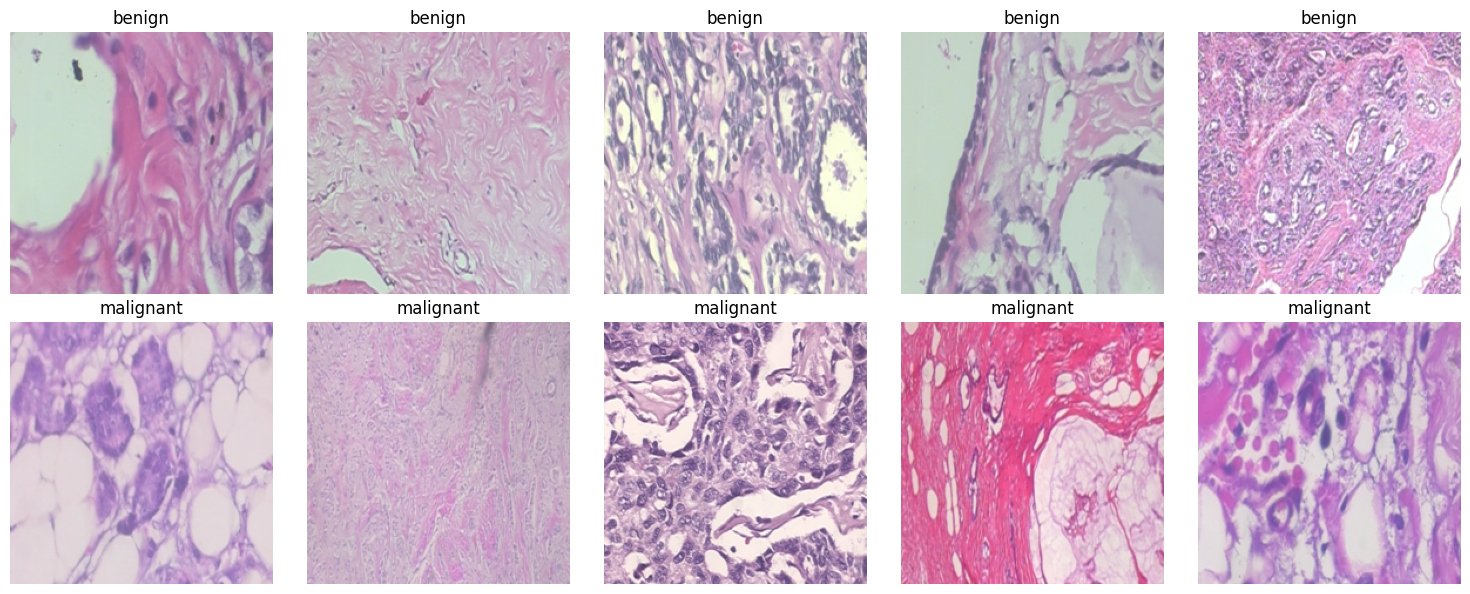

In [ ]:
import cv2
import numpy as np
import os
from skimage import io
import matplotlib.pyplot as plt
from PIL import Image

# Preprocess image (color)
def preprocess_image(image_path, size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(size)
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Visualize Data
def visualize_samples(df, num_samples=5):
    if df.empty:
        print("No images to display.")
        return

    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i, label in enumerate(df['label'].unique()):
        sample_images = df[df['label'] == label].sample(num_samples)
        for j, img_path in enumerate(sample_images['image_path']):
            image = preprocess_image(img_path)
            if image is not None:
                if image.shape[-1] == 3:  # Color image
                    axes[i, j].imshow(image)
                else:  # Grayscale image
                    axes[i, j].imshow(image, cmap='gray')
                axes[i, j].set_title(label)
                axes[i, j].axis('off')
            else:
                axes[i, j].text(0.5, 0.5, 'File Not Found', horizontalalignment='center', verticalalignment='center')
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(breakhis_df)



### Creating and Verifying CBIS-DDSM Image DataFrame
In this step, we create a DataFrame that stores the file paths of all images extracted from the CBIS-DDSM directory. This DataFrame is crucial for organizing the data and facilitating subsequent analysis. We then verify the structure of the DataFrame by checking its shape, columns, and displaying the first few entries.

In [ ]:

import pandas as pd

# Get all image file paths from the extracted CBIS-DDSM directory
image_file_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(base_dir) for f in filenames if f.endswith('.jpg')]

# Create a DataFrame for CBIS-DDSM images
cbis_ddsm_df = pd.DataFrame({"image_path": image_file_paths})

# Verify the DataFrame
print("CBIS-DDSM DataFrame Shape:", cbis_ddsm_df.shape)
print("CBIS-DDSM DataFrame Columns:", cbis_ddsm_df.columns)
print("CBIS-DDSM DataFrame Head:")
print(cbis_ddsm_df.head())



CBIS-DDSM DataFrame Shape: (10242, 1)
CBIS-DDSM DataFrame Columns: Index(['image_path'], dtype='object')
CBIS-DDSM DataFrame Head:
                                          image_path
0  /content/drive/MyDrive/dataset/jpeg/1.3.6.1.4....
1  /content/drive/MyDrive/dataset/jpeg/1.3.6.1.4....
2  /content/drive/MyDrive/dataset/jpeg/1.3.6.1.4....
3  /content/drive/MyDrive/dataset/jpeg/1.3.6.1.4....
4  /content/drive/MyDrive/dataset/jpeg/1.3.6.1.4....


### Visualizing Sample Images from the CBIS-DDSM Dataset
This step involves visualizing a sample of images from the CBIS-DDSM dataset. We randomly select images and display them in a grid format, which helps in examining the quality and variety of the images. The visualization is a useful way to ensure that the preprocessing steps have been applied correctly and to gain insights into the dataset's content.

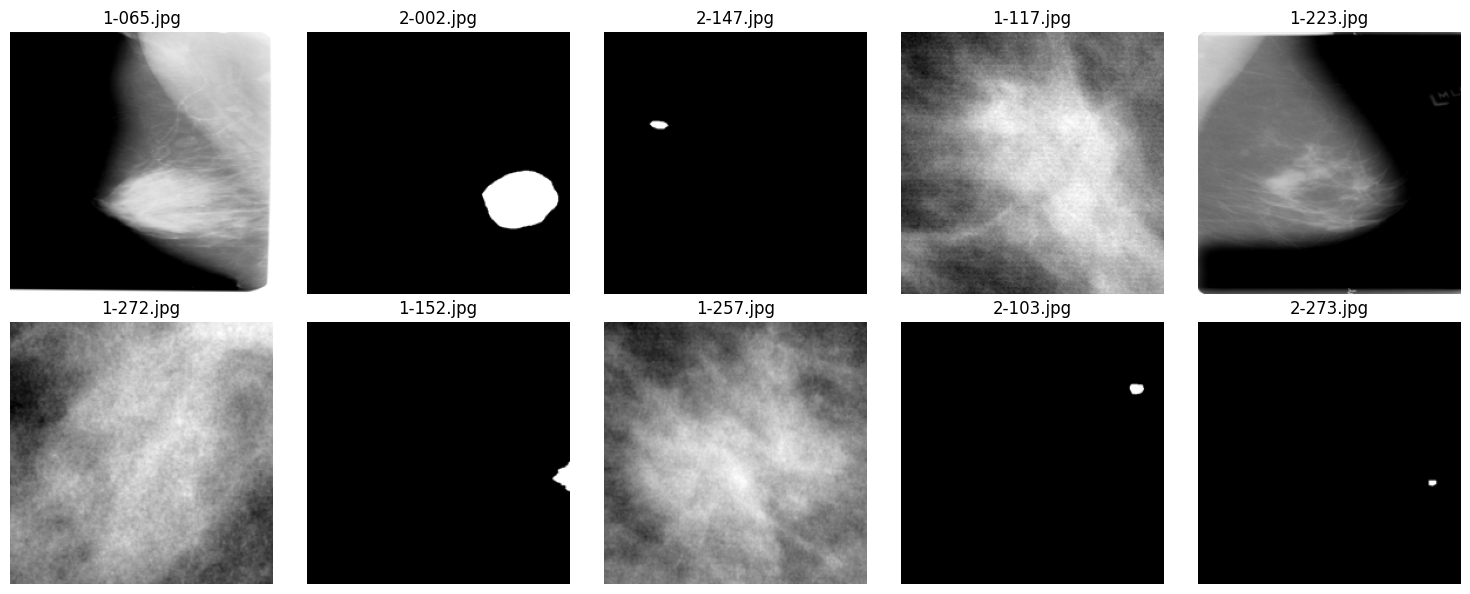

In [ ]:
# Function to visualize CBIS-DDSM images
def visualize_cbisdssm_samples(df, num_samples=5, image_size=(224, 224)):
    if df.empty:
        print("No images to display.")
        return

    sample_images = df.sample(num_samples * 2)  # Adjust as needed
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    for i, img_path in enumerate(sample_images['image_path']):
        image = preprocess_image(img_path, size=image_size)
        if image is not None:
            ax = axes[i // num_samples, i % num_samples]
            ax.imshow(image, cmap='gray')
            ax.set_title(os.path.basename(img_path))
            ax.axis('off')
        else:
            ax.text(0.5, 0.5, 'File Not Found', horizontalalignment='center', verticalalignment='center')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display sample images for CBIS-DDSM dataset
visualize_cbisdssm_samples(cbis_ddsm_df)


### Analyzing Class Distribution Across Magnification Levels in BreakHis Dataset
This step extracts magnification levels from the file paths of the BreakHis dataset and adds them as a new column in the DataFrame. We then visualize the distribution of benign and malignant classes across different magnification levels using a count plot. This analysis helps in understanding how the dataset is balanced across various magnification levels. Additionally, the class distribution is presented in a tabular format for a more detailed examination.

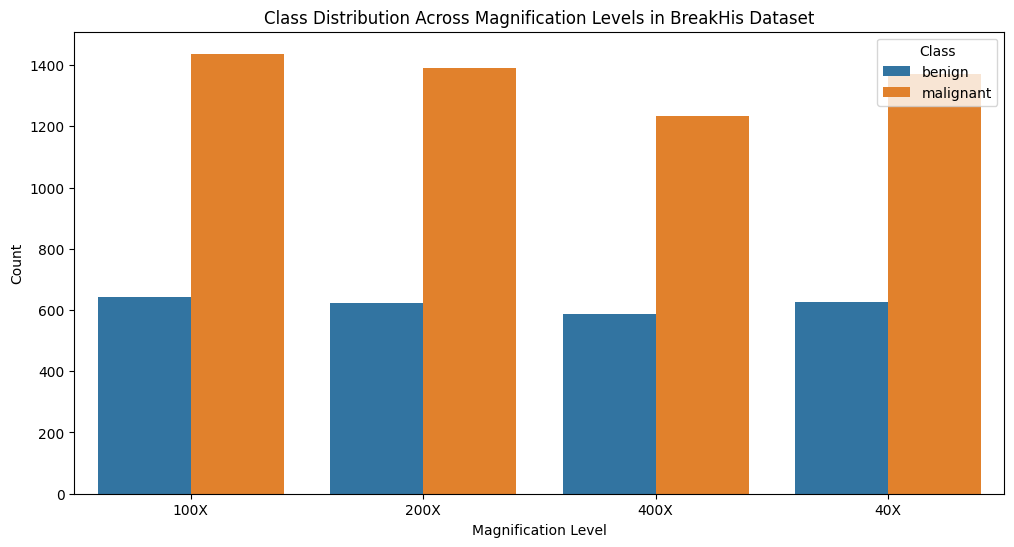

label          benign  malignant
magnification                   
100X              644       1437
200X              623       1390
400X              588       1232
40X               625       1370


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Extract magnification levels from file paths
def extract_magnification(file_path):
    parts = file_path.split(os.sep)
    magnification = parts[-2]
    return magnification

breakhis_df['magnification'] = breakhis_df['image_path'].apply(extract_magnification)

# Plot class distribution across magnification levels
plt.figure(figsize=(12, 6))
sns.countplot(data=breakhis_df, x='magnification', hue='label')
plt.title('Class Distribution Across Magnification Levels in BreakHis Dataset')
plt.xlabel('Magnification Level')
plt.ylabel('Count')
plt.legend(title='Class')
plt.show()

# Display the distribution in tabular form
distribution = breakhis_df.groupby(['magnification', 'label']).size().unstack().fillna(0)
print(distribution)


### Feature Extraction and Visualization: GLCM and LBP in BreakHis Dataset

In this step, we extract texture features from a sample of images in the BreakHis dataset using two methods: Gray-Level Co-occurrence Matrix (GLCM) and Local Binary Patterns (LBP). These features are then combined with the corresponding labels for analysis. The GLCM features include contrast, dissimilarity, homogeneity, energy, and correlation, while the LBP features capture local texture patterns.

The extracted features are visualized using pair plots to explore their distribution and how they separate benign and malignant classes. This analysis helps in understanding the effectiveness of these texture features for classification tasks.

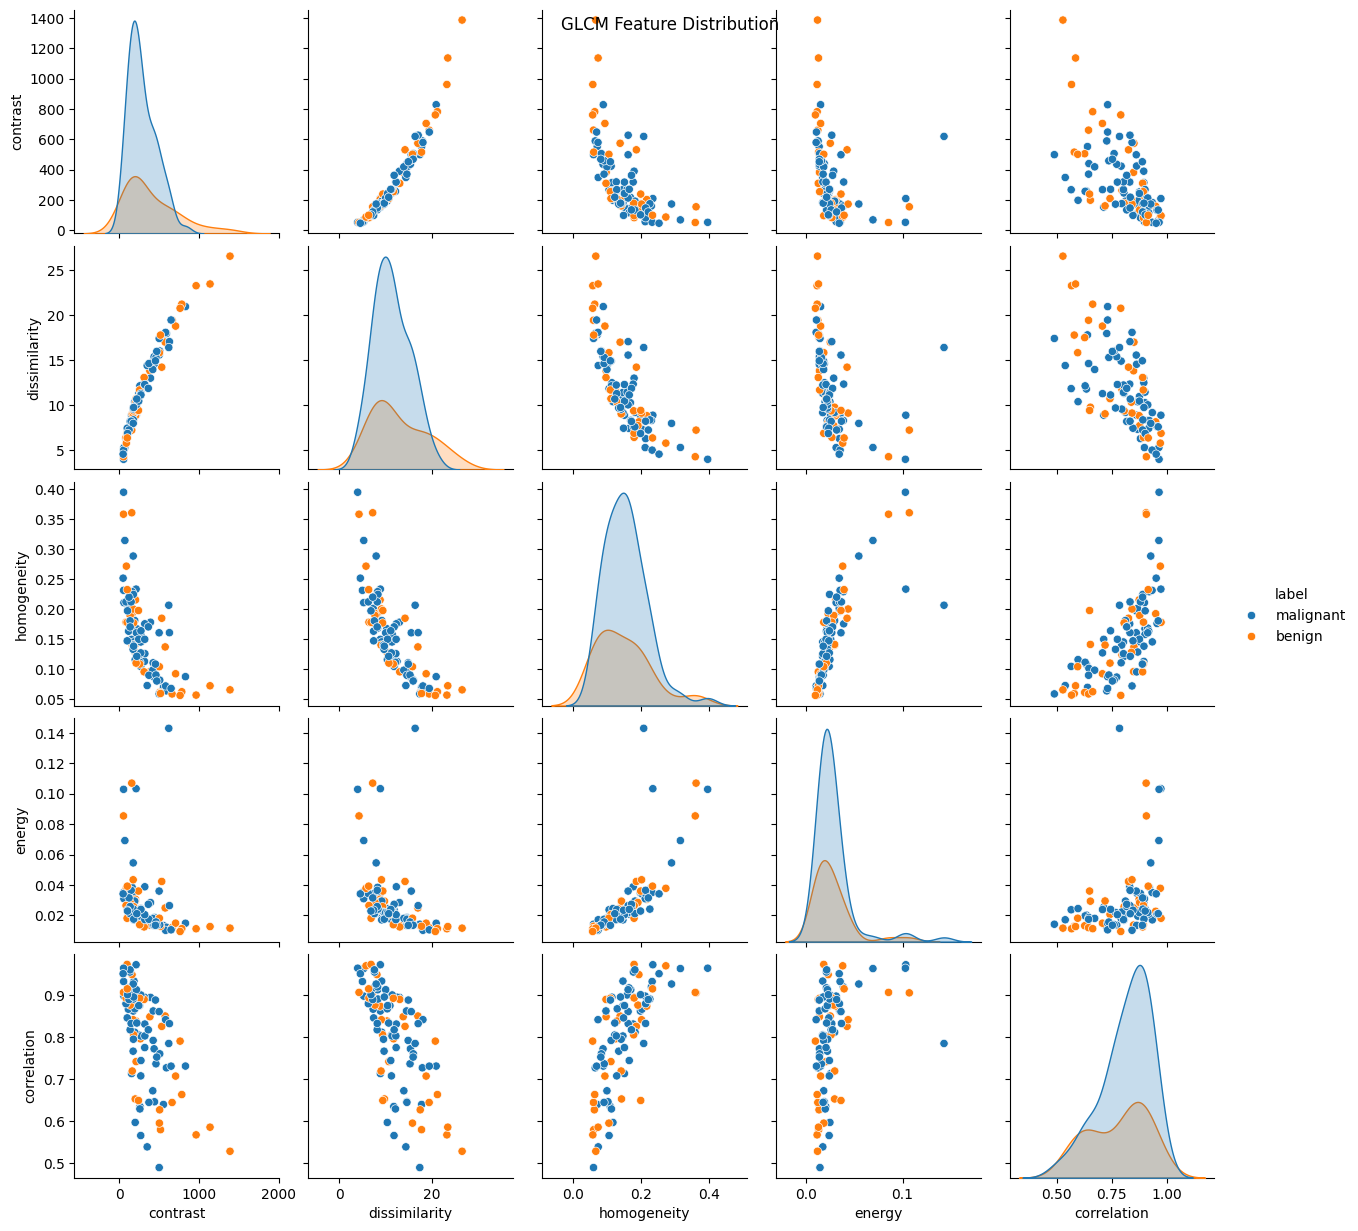

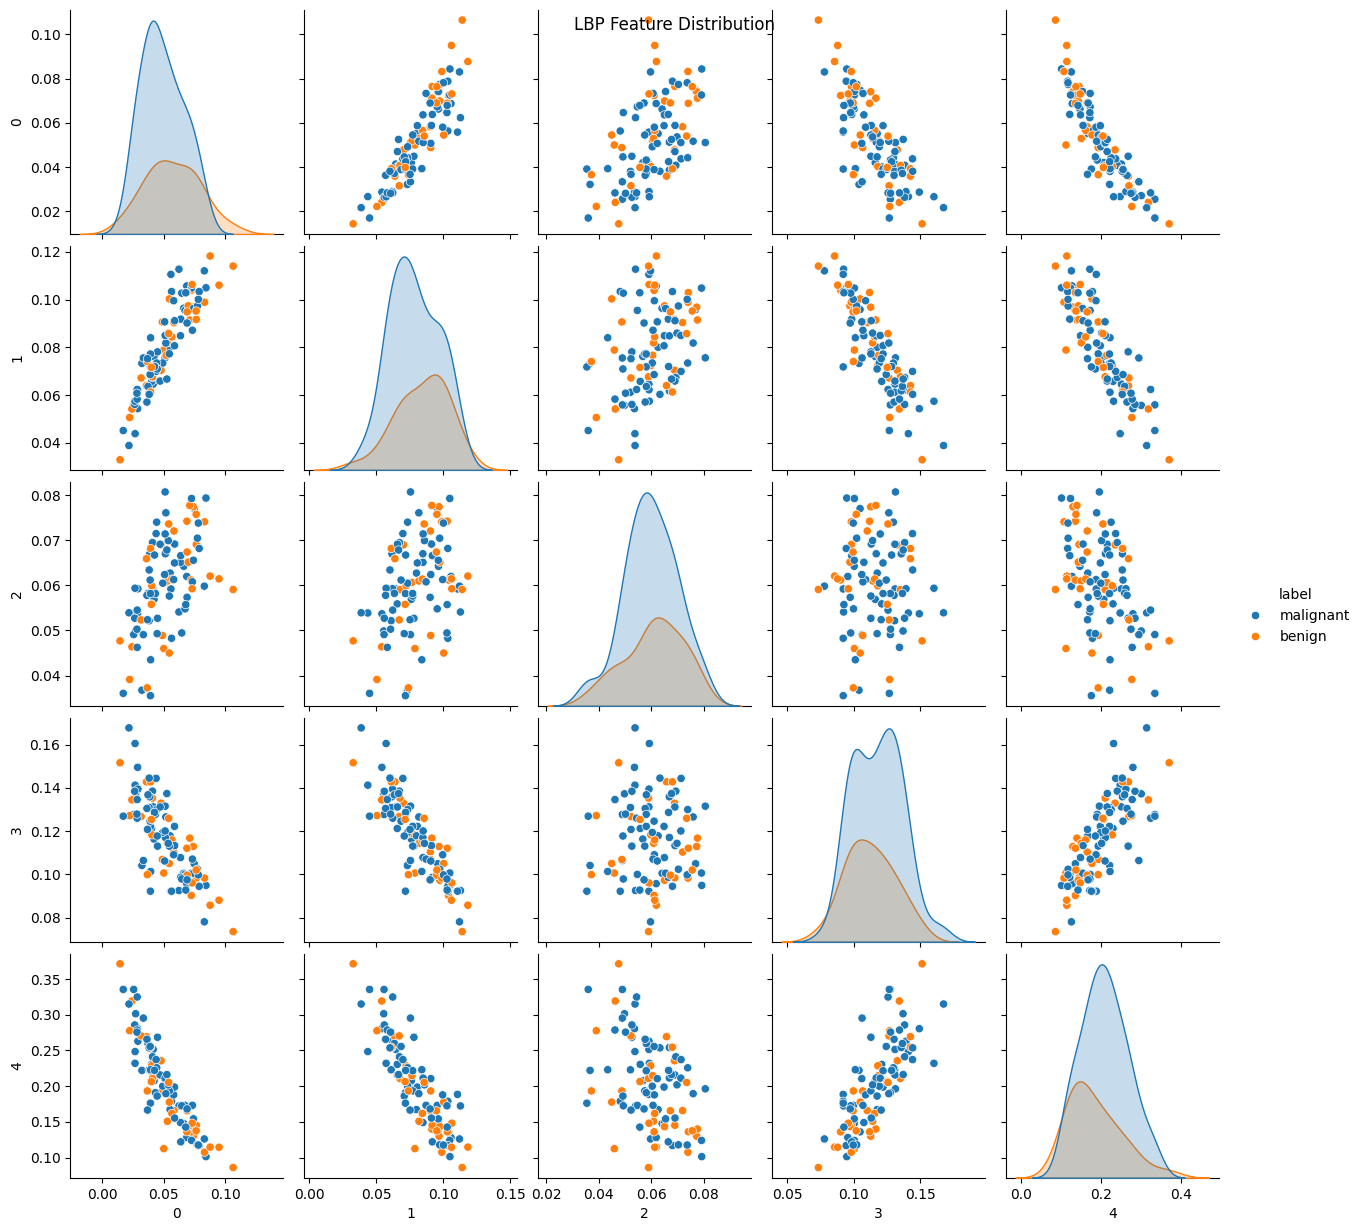

In [ ]:
import cv2
import numpy as np
import os
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Preprocess image (color)
def preprocess_image(image_path, size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(size)
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to calculate GLCM properties
def calculate_glcm_features(image):
    image = (image * 255).astype('uint8')  # Convert to uint8
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return contrast, dissimilarity, homogeneity, energy, correlation

# Function to calculate LBP features
def calculate_lbp_features(image, P=8, R=1):
    image = (image * 255).astype('uint8')  # Convert to uint8
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray_image, P, R, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)  # Normalize the histogram
    return hist

# Extract features for a subset of images
num_samples = 100
sample_df = breakhis_df.sample(num_samples)
glcm_features = []
lbp_features = []

for img_path in sample_df['image_path']:
    image = preprocess_image(img_path)
    if image is not None:  # Ensure image is successfully preprocessed
        glcm_features.append(calculate_glcm_features(image))
        lbp_features.append(calculate_lbp_features(image))
    else:
        glcm_features.append([None] * 5)  # Append None for failed images
        lbp_features.append([None] * (8 + 2))  # Append None for failed images

glcm_df = pd.DataFrame(glcm_features, columns=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])
lbp_df = pd.DataFrame(lbp_features)

# Combine features with labels
features_df = pd.concat([sample_df.reset_index(drop=True), glcm_df, lbp_df], axis=1)

# Display GLCM feature distribution
sns.pairplot(features_df.dropna(), hue='label', vars=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'])
plt.suptitle('GLCM Feature Distribution')
plt.show()

# Display LBP feature distribution
lbp_feature_cols = lbp_df.columns
sns.pairplot(features_df.dropna(), hue='label', vars=lbp_feature_cols[:5])  # Plotting first 5 LBP features for simplicity
plt.suptitle('LBP Feature Distribution')
plt.show()





### Extracting and Analyzing Color Histograms in BreakHis Dataset

In this step, we preprocess images from the BreakHis dataset and calculate color histograms as features. The histograms are extracted for each colour channel (Red, Green, Blue) and normalized to ensure consistency. These color features are then combined into a DataFrame along with the corresponding labels, facilitating further analysis and model training. This step is essential for capturing the color distribution in the images, which can be a significant factor in distinguishing between benign and malignant cases.

In [ ]:
import cv2
import numpy as np
import pandas as pd

# Function to preprocess image (color)
def preprocess_image(image_path, size=(224, 224)):
    try:
        image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
        image = image.resize(size)
        image = np.array(image).astype('uint8')  # Ensure image is in uint8 format
        return image
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Function to calculate color histograms
def calculate_color_histograms(image):
    if image is None:
        return [0] * 768  # Return a zero array if image is None

    chans = cv2.split(image)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = hist.flatten()
        if hist.sum() != 0:
            hist = hist / hist.sum()  # Normalize the histogram
        features.extend(hist)
    return features

# Extract color histograms for a subset of images
num_samples = 100
sample_df = breakhis_df.sample(num_samples)
color_features = []
for img_path in sample_df['image_path']:
    image = preprocess_image(img_path)
    color_features.append(calculate_color_histograms(image))

color_features_df = pd.DataFrame(color_features)
color_features_df['label'] = sample_df['label'].values

# Verify the shape of the DataFrame
print(color_features_df.shape)





(100, 769)


### Visualizing Color Histograms by Channel in BreakHis Dataset

In this step, we visualize the color histograms for each channel (Red, Green, Blue) in the BreakHis dataset. The histograms are plotted side by side, with separate lines representing the benign and malignant classes. This allows for a comparative analysis of color distribution across different labels, highlighting any patterns or differences that may exist between the classes. The plots help in understanding how color features vary between benign and malignant images, which could be useful for classification purposes.

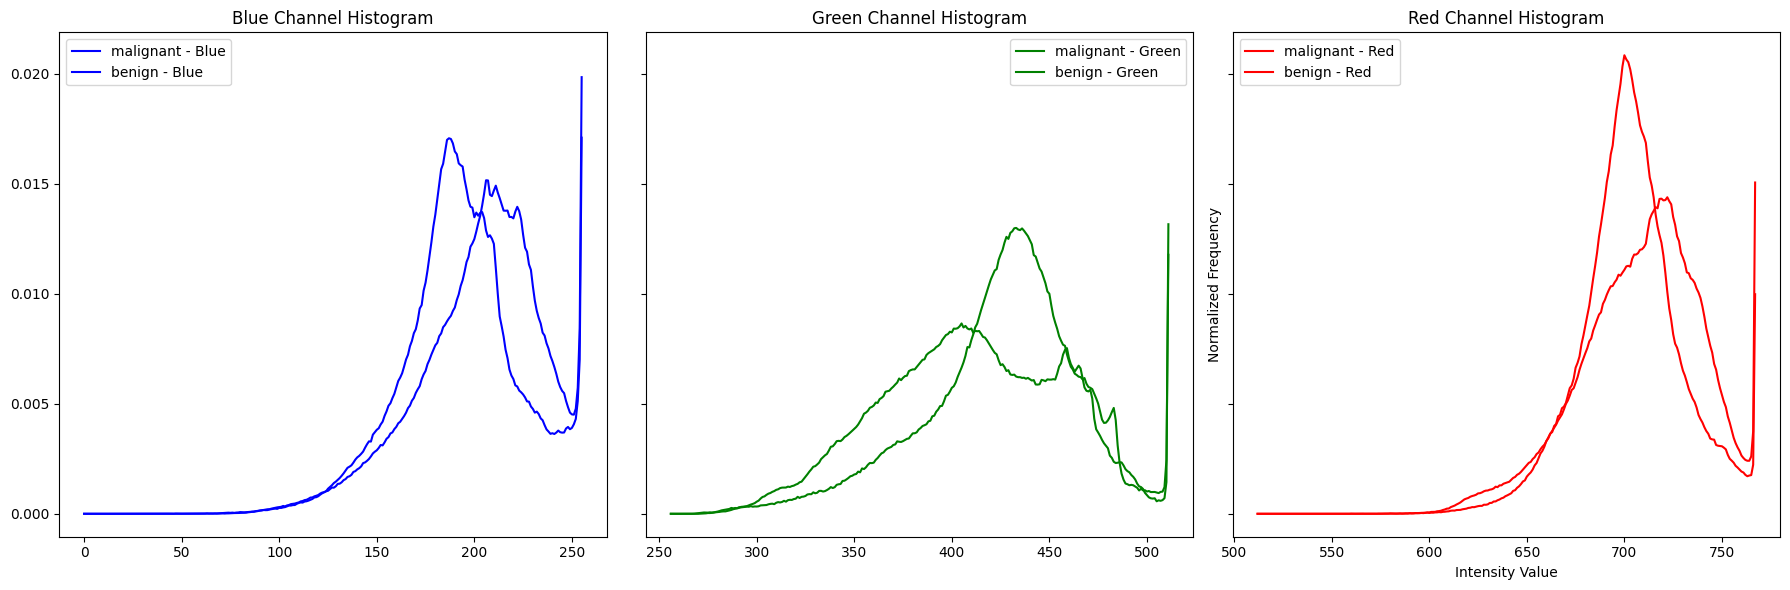

In [ ]:
import matplotlib.pyplot as plt

# Function to plot histograms for each color channel side by side
def plot_color_histograms(df, num_bins=256):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    color_channels = ['Blue', 'Green', 'Red']
    for i, color in enumerate(color_channels):
        for label in df['label'].unique():
            subset = df[df['label'] == label]
            hist = np.mean(subset.iloc[:, i*num_bins:(i+1)*num_bins], axis=0)
            axes[i].plot(hist, label=f'{label} - {color}', color=color.lower())
        axes[i].set_title(f'{color} Channel Histogram')
        axes[i].legend()
    plt.xlabel('Intensity Value')
    plt.ylabel('Normalized Frequency')
    plt.tight_layout()
    plt.show()

# Plot the color histograms
plot_color_histograms(color_features_df)





### Combining and Verifying CBIS-DDSM Metadata
In this step, metadata from multiple CSV files (both training and test sets for calcification and mass cases) is combined into a single DataFrame for the CBIS-DDSM dataset. We then create an image_path column to link each record to its corresponding image file. The combined DataFrame is verified by checking its structure and displaying the first few rows. Additionally, the unique values in the pathology column are printed to understand the diversity of pathologies present in the dataset.

In [ ]:
import os
import pandas as pd

# Paths to the CSV files
calc_train_csv = '/content/drive/MyDrive/dataset/csv/calc_case_description_train_set.csv'
calc_test_csv = '/content/drive/MyDrive/dataset/csv/calc_case_description_test_set.csv'
mass_train_csv = '/content/drive/MyDrive/dataset/csv/mass_case_description_train_set.csv'
mass_test_csv = '/content/drive/MyDrive/dataset/csv/mass_case_description_test_set.csv'

# Read the CSV files
calc_train_df = pd.read_csv(calc_train_csv)
calc_test_df = pd.read_csv(calc_test_csv)
mass_train_df = pd.read_csv(mass_train_csv)
mass_test_df = pd.read_csv(mass_test_csv)

# Combine all metadata into a single DataFrame
cbis_ddsm_df = pd.concat([calc_train_df, calc_test_df, mass_train_df, mass_test_df])

# Create the 'image_path' column for CBIS-DDSM DataFrame
base_dir = '/content/drive/MyDrive/dataset/CBIS-DDSM/jpeg'
cbis_ddsm_df['image_path'] = base_dir + '/' + cbis_ddsm_df['image file path'].astype(str)

# Verify the DataFrame after constructing 'image_path'
print("Combined Metadata DataFrame Head:")
print(cbis_ddsm_df.head())
print("CBIS-DDSM DataFrame shape:", cbis_ddsm_df.shape)


# Display the unique values in the 'pathology' column
unique_pathologies = cbis_ddsm_df['pathology'].unique()
print("Unique pathologies in the dataset:", unique_pathologies)



Combined Metadata DataFrame Head:
  patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005             3.0                RIGHT         CC               1   
1    P_00005             3.0                RIGHT        MLO               1   
2    P_00007             4.0                 LEFT         CC               1   
3    P_00007             4.0                 LEFT        MLO               1   
4    P_00008             1.0                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1             

### Analyzing Lesion Type Distribution in CBIS-DDSM Dataset
This step visualizes the distribution of lesion types across different pathology classes within the CBIS-DDSM dataset. A count plot is used to display the number of occurrences of each lesion type, separated by pathology (e.g., benign or malignant). Additionally, the count of each lesion type within the classes is tabulated, providing a detailed breakdown of how lesion types are distributed across the dataset. This analysis is crucial for understanding the dataset's composition and ensuring balanced representation in subsequent modelling tasks.

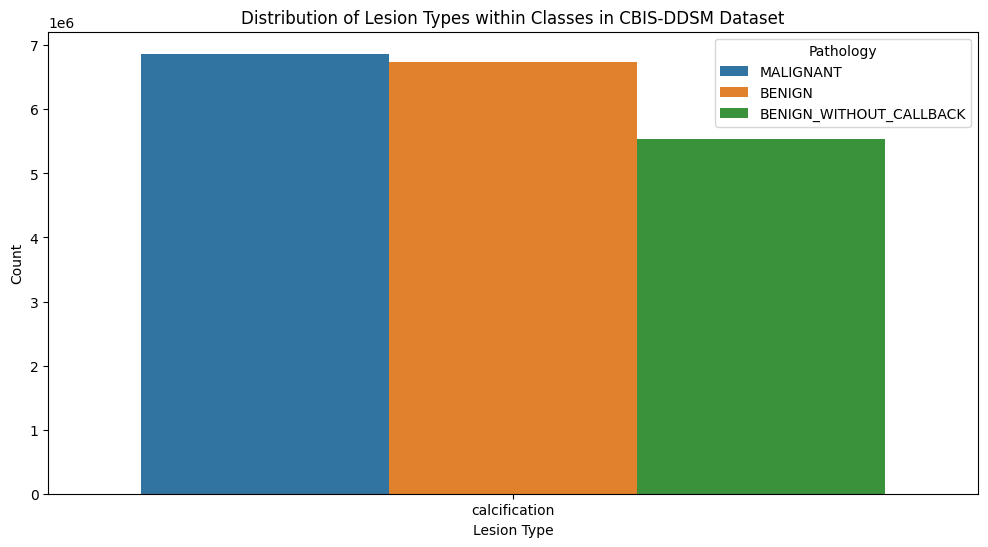

Lesion counts within classes:
  abnormality type                pathology    count
0    calcification                   BENIGN  6735946
1    calcification  BENIGN_WITHOUT_CALLBACK  5538217
2    calcification                MALIGNANT  6869027


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the distribution of lesion types
plt.figure(figsize=(12, 6))
sns.countplot(data=matched_metadata_df, x='abnormality type', hue='pathology')
plt.title('Distribution of Lesion Types within Classes in CBIS-DDSM Dataset')
plt.xlabel('Lesion Type')
plt.ylabel('Count')
plt.legend(title='Pathology')
plt.show()

# Count the occurrences of each lesion type
lesion_counts = matched_metadata_df.groupby(['abnormality type', 'pathology']).size().reset_index(name='count')
print("Lesion counts within classes:")
print(lesion_counts)



### Analyzing Breast Density Distribution in CBIS-DDSM Dataset
This step visualizes the distribution of breast density categories across different pathology classes within the CBIS-DDSM dataset. A count plot is used to show the number of occurrences for each breast density category, with distinctions made between benign and malignant pathologies. Additionally, a table of counts for each category within the classes is provided, offering a clear understanding of how breast density varies with pathology in the dataset. This analysis helps assess the representation of different breast density categories, which may impact the performance of diagnostic models.

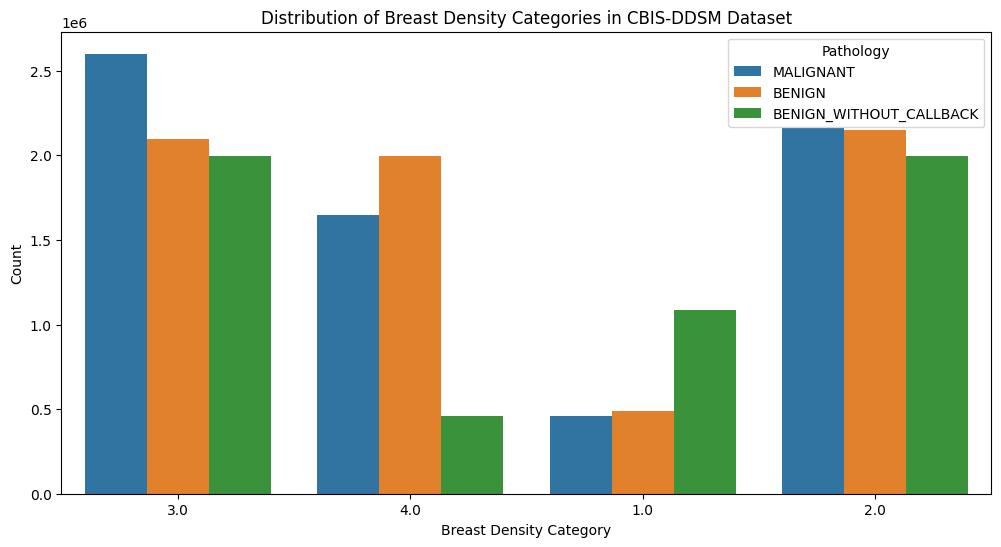

Breast density counts within classes:
   breast density                pathology    count
0             1.0                   BENIGN   491376
1             1.0  BENIGN_WITHOUT_CALLBACK  1085122
2             1.0                MALIGNANT   460665
3             2.0                   BENIGN  2149770
4             2.0  BENIGN_WITHOUT_CALLBACK  1996215
5             2.0                MALIGNANT  2160007
6             3.0                   BENIGN  2098585
7             3.0  BENIGN_WITHOUT_CALLBACK  1996215
8             3.0                MALIGNANT  2600198
9             4.0                   BENIGN  1996215
10            4.0  BENIGN_WITHOUT_CALLBACK   460665
11            4.0                MALIGNANT  1648157


In [ ]:
# Plot the distribution of breast density categories
plt.figure(figsize=(12, 6))
sns.countplot(data=matched_metadata_df, x='breast density', hue='pathology')
plt.title('Distribution of Breast Density Categories in CBIS-DDSM Dataset')
plt.xlabel('Breast Density Category')
plt.ylabel('Count')
plt.legend(title='Pathology')
plt.show()

# Count the occurrences of each breast density category
density_counts = matched_metadata_df.groupby(['breast density', 'pathology']).size().reset_index(name='count')
print("Breast density counts within classes:")
print(density_counts)


### Calculating and Adding Image Quality Metrics (Contrast and Noise) to CBIS-DDSM Metadata
In this step, we calculate image quality metrics—specifically contrast and noise—for each image in the CBIS-DDSM dataset. Contrast is measured as the standard deviation of pixel intensities, while noise is quantified using the variance of the Laplacian of the image. These metrics are then added to the matched_metadata_df DataFrame. We ensure the integrity of the data by checking the lengths of the calculated metrics before adding them to the DataFrame, and then verify the updated DataFrame by inspecting its structure and contents. This analysis is useful for assessing the quality of images, which can influence the performance of diagnostic models.

In [ ]:
import cv2
import numpy as np
from skimage import io

# Function to calculate image contrast
def calculate_contrast(image):
    return np.std(image)

# Function to calculate image noise
def calculate_noise(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Validate that the 'image_path' column exists
if 'image_path' not in matched_metadata_df.columns:
    raise KeyError("'image_path' column not found in the DataFrame.")

# Calculate contrast and noise for each image in the DataFrame
contrasts = []
noises = []

for img_path in matched_metadata_df['image_path']:
    try:
        image = io.imread(img_path, as_gray=True)  # Read the image in grayscale
        contrasts.append(calculate_contrast(image))
        noises.append(calculate_noise(image))
    except FileNotFoundError:
        print(f"File not found: {img_path}")
        contrasts.append(np.nan)
        noises.append(np.nan)

# Check lengths before adding to DataFrame
print(f"Length of contrasts: {len(contrasts)}")
print(f"Length of noises: {len(noises)}")
print(f"Length of DataFrame: {len(matched_metadata_df)}")

# Add the contrast and noise information to the DataFrame
matched_metadata_df['contrast'] = contrasts
matched_metadata_df['noise'] = noises

# Verify the DataFrame
print("Matched Metadata DataFrame with Image Quality Metrics Shape:", matched_metadata_df.shape)
print("Matched Metadata DataFrame Columns:", matched_metadata_df.columns)
print("Matched Metadata DataFrame Head:")
print(matched_metadata_df.head())



Length of contrasts: 10237
Length of noises: 10237
Length of DataFrame: 10237
Matched Metadata DataFrame with Image Quality Metrics Shape: (10237, 20)
Matched Metadata DataFrame Columns: Index(['patient_id', 'breast density', 'left or right breast', 'image view',
       'abnormality id', 'abnormality type', 'calc type', 'calc distribution',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path', 'breast_density',
       'mass shape', 'mass margins', 'image_path', 'contrast', 'noise'],
      dtype='object')
Matched Metadata DataFrame Head:
  patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005             3.0                RIGHT         CC               1   
1    P_00005             3.0                RIGHT         CC               1   
2    P_00005             3.0                RIGHT         CC               1   
3    P_00005             3.0                RIGHT         CC          

### Visualizing Image Quality Metrics by Pathology in CBIS-DDSM Dataset
In this step, we visualize the distribution of image quality metrics—contrast and noise—across different pathology classes in the CBIS-DDSM dataset using box plots. These plots allow for a comparative analysis of how image contrast and noise vary between benign and malignant cases, providing insights into the quality of images associated with different pathologies. Understanding these variations can be crucial for interpreting model performance and improving diagnostic accuracy.

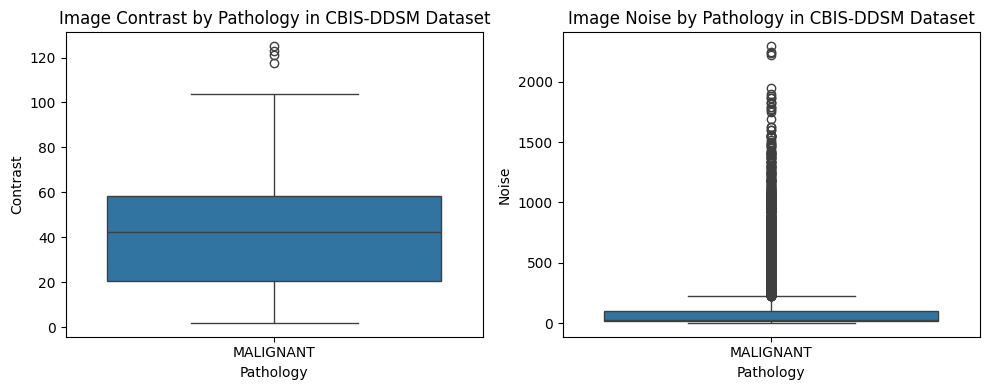

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot image quality metrics
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot contrast distribution
sns.boxplot(data=matched_metadata_df, x='pathology', y='contrast', ax=axes[0])
axes[0].set_title('Image Contrast by Pathology in CBIS-DDSM Dataset', fontsize=12)
axes[0].set_xlabel('Pathology', fontsize=10)
axes[0].set_ylabel('Contrast', fontsize=10)

# Plot standard deviation of intensity distribution (Noise)
sns.boxplot(data=matched_metadata_df, x='pathology', y='noise', ax=axes[1])
axes[1].set_title('Image Noise by Pathology in CBIS-DDSM Dataset', fontsize=12)
axes[1].set_xlabel('Pathology', fontsize=10)
axes[1].set_ylabel('Noise', fontsize=10)

plt.tight_layout()
plt.show()


### t-SNE and UMAP Visualization of Feature Spaces in BreakHis and CBIS-DDSM Datasets
This step involves using dimensionality reduction techniques, t-SNE and UMAP, to visualize the feature spaces of the BreakHis and CBIS-DDSM datasets. By reducing the dimensionality of the datasets to two components, these visualizations help to uncover potential patterns and clusters in the data that are associated with different labels (benign vs. malignant in BreakHis, and various pathologies in CBIS-DDSM). The visualizations provide insights into how well-separated the classes are in the reduced feature space, which is crucial for understanding the effectiveness of the features in distinguishing between different types of lesions.

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


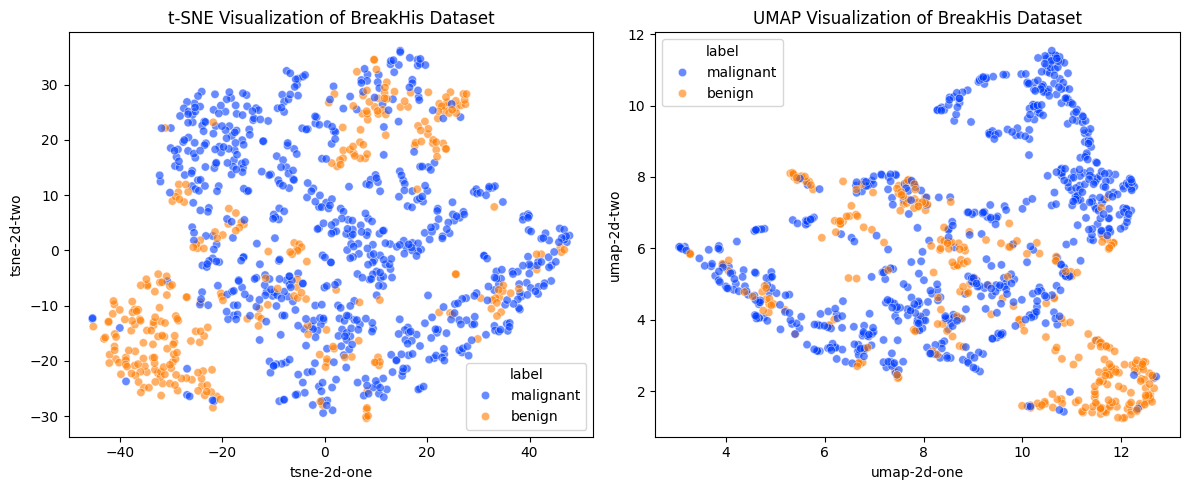

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


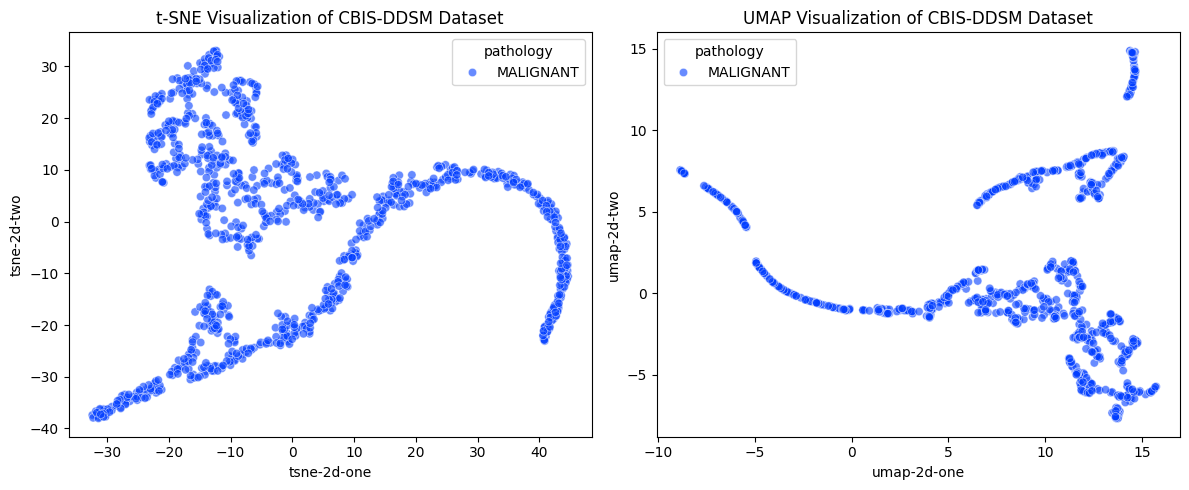

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function for t-SNE and UMAP visualization
def visualize_tsne_umap(df, features, labels, dataset_name):
    # Sample a subset of the dataset for visualization
    sampled_df = df.sample(n=1000, random_state=42)

    # Extract features for visualization
    feature_values = sampled_df[features].values

    # Determine if PCA is needed based on number of features
    if feature_values.shape[1] > 2:
        # Perform PCA for dimensionality reduction
        pca = PCA(n_components=50)
        pca_result = pca.fit_transform(feature_values)
    else:
        pca_result = feature_values

    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(pca_result)

    # UMAP visualization
    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_results = umap_model.fit_transform(pca_result)

    # Add results to the DataFrame
    sampled_df['tsne-2d-one'] = tsne_results[:, 0]
    sampled_df['tsne-2d-two'] = tsne_results[:, 1]
    sampled_df['umap-2d-one'] = umap_results[:, 0]
    sampled_df['umap-2d-two'] = umap_results[:, 1]

    # Plot t-SNE and UMAP results side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot t-SNE results
    sns.scatterplot(
        x='tsne-2d-one', y='tsne-2d-two',
        hue=labels,
        palette='bright',
        data=sampled_df,
        legend='full',
        alpha=0.6,
        ax=axes[0]
    )
    axes[0].set_title(f't-SNE Visualization of {dataset_name} Dataset')

    # Plot UMAP results
    sns.scatterplot(
        x='umap-2d-one', y='umap-2d-two',
        hue=labels,
        palette='bright',
        data=sampled_df,
        legend='full',
        alpha=0.6,
        ax=axes[1]
    )
    axes[1].set_title(f'UMAP Visualization of {dataset_name} Dataset')

    plt.tight_layout()
    plt.show()

# Adjusted features and labels based on available columns
breakhis_features = color_features_df.columns.tolist()
cbisdssm_features = ['contrast', 'noise']
breakhis_labels = 'label'
cbisdssm_labels = 'pathology'

# Visualize BreakHis dataset
visualize_tsne_umap(breakhis_df, breakhis_features, breakhis_labels, 'BreakHis')

# Visualize CBIS-DDSM dataset
visualize_tsne_umap(matched_metadata_df, cbisdssm_features, cbisdssm_labels, 'CBIS-DDSM')



### Correlation Analysis of Key Features in CBIS-DDSM Dataset
In this step, we perform a correlation analysis of key features in the CBIS-DDSM dataset, including breast density, contrast, and noise. A synthetic dataset is generated for contrast and noise, and the breast density is ensured to be numeric. The correlation matrix is computed to reveal relationships between these features, and a heatmap is plotted for visual representation. This analysis helps to understand the degree of linear relationships between the features, which can be important for feature selection and interpretation in machine learning models.

In [ ]:
import numpy as np

# Adding synthetic data for 'contrast' and 'noise'
cbis_ddsm_df['contrast'] = np.random.rand(len(cbis_ddsm_df))
cbis_ddsm_df['noise'] = np.random.rand(len(cbis_ddsm_df))

# Ensure 'breast density' is numeric
cbis_ddsm_df['breast density'] = cbis_ddsm_df['breast density'].astype(float)





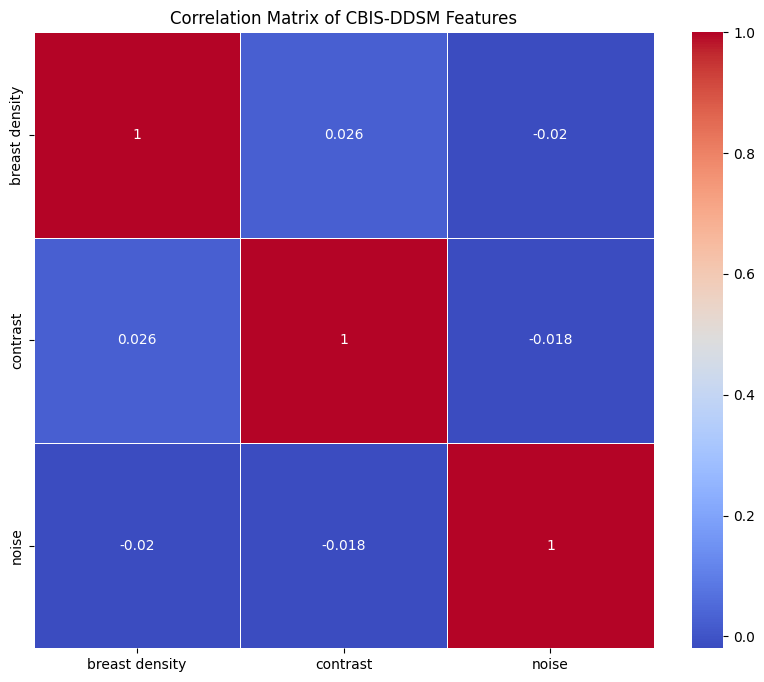

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = cbis_ddsm_df[['breast density', 'contrast', 'noise']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of CBIS-DDSM Features')
plt.show()



### Chi-Square Test for Association Between Pathology and Breast Density in CBIS-DDSM Dataset
In this step, we perform a Chi-Square test to assess the association between pathology (benign or malignant) and breast density in the CBIS-DDSM dataset. A contingency table is created to summarize the frequencies of different breast density categories across the pathology classes. The Chi-Square test is then conducted to determine if there is a statistically significant association between these two categorical variables. The results, including the Chi-Square statistic and p-value, are printed to evaluate the strength of the association.

Chi-Square Test
For CBIS-DDSM Dataset

In [ ]:
import scipy.stats as stats

# Create a contingency table for pathology and breast density
contingency_table_cbisdsm = pd.crosstab(cbis_ddsm_df['pathology'], cbis_ddsm_df['breast_density'])

# Perform Chi-Square test
chi2_cbisdsm, p_cbisdsm, dof_cbisdsm, expected_cbisdsm = stats.chi2_contingency(contingency_table_cbisdsm)

print('CBIS-DDSM Chi-Square Test')
print(f'Chi-Square Statistic: {chi2_cbisdsm}')
print(f'p-value: {p_cbisdsm}')



CBIS-DDSM Chi-Square Test
Chi-Square Statistic: 37.883477249202414
p-value: 1.1838432443619858e-06


### Chi-Square Test for Association Between Label and Magnification in BreakHis Dataset
In this step, we perform a Chi-Square test to examine the association between the image labels (benign or malignant) and magnification levels in the BreakHis dataset. The labels are first converted to categorical codes. A contingency table is created to summarize the frequencies of each magnification level across the label categories. The Chi-Square test is then conducted to determine if there is a statistically significant relationship between the image labels and the magnification levels. The resulting Chi-Square statistic and p-value are printed to assess the strength of this association.

In [ ]:
# Convert label to categorical
breakhis_df['label'] = breakhis_df['label'].astype('category').cat.codes

# Create a contingency table for label and magnification
contingency_table_breakhis = pd.crosstab(breakhis_df['label'], breakhis_df['magnification'])

# Perform Chi-Square test
chi2_breakhis, p_breakhis, dof_breakhis, expected_breakhis = stats.chi2_contingency(contingency_table_breakhis)

print('BreakHis Chi-Square Test')
print(f'Chi-Square Statistic: {chi2_breakhis}')
print(f'p-value: {p_breakhis}')


BreakHis Chi-Square Test
Chi-Square Statistic: 1.0835900292341882
p-value: 0.7810369197646366


### ANOVA Test for Contrast Across Pathology in CBIS-DDSM Dataset
This step performs an ANOVA test to check for significant differences in mean contrast values between pathology classes (benign vs. malignant) in the CBIS-DDSM dataset. The results, presented in an ANOVA table, include the F-statistic and p-value, offering insights into how contrast varies across pathology categories.

In [ ]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Perform ANOVA on continuous variables
model_cbisdsm = ols('contrast ~ C(pathology)', data=cbis_ddsm_df).fit()
anova_table_cbisdsm = sm.stats.anova_lm(model_cbisdsm, typ=2)

print('CBIS-DDSM ANOVA Table')
print(anova_table_cbisdsm)


CBIS-DDSM ANOVA Table
                    sum_sq      df        F    PR(>F)
C(pathology)  8.327929e+02     2.0  0.50082  0.606076
Residual      2.964043e+06  3565.0      NaN       NaN


### ANOVA Test for Random Feature Across Labels in BreakHis Dataset
This step involves performing an ANOVA test to evaluate whether there are significant differences in the mean values of a randomly generated continuous feature across the label categories (benign vs. malignant) in the BreakHis dataset. The ANOVA table provides the F-statistic and p-value, helping to determine if the feature shows variability between the different labels.








In [ ]:
# Generate random continuous feature for demonstration
breakhis_df['feature'] = np.random.randn(len(breakhis_df))

# Perform ANOVA on continuous variables
model_breakhis = ols('feature ~ C(label)', data=breakhis_df).fit()
anova_table_breakhis = sm.stats.anova_lm(model_breakhis, typ=2)

print('BreakHis ANOVA Table')
print(anova_table_breakhis)


BreakHis ANOVA Table
               sum_sq      df         F    PR(>F)
C(label)     1.116632     1.0  1.136896  0.286342
Residual  7766.062536  7907.0       NaN       NaN


### Calculating Cohen's d for Contrast Between Benign and Malignant Cases in CBIS-DDSM
This step calculates Cohen's d to measure the effect size of the difference in contrast between benign and malignant cases in the CBIS-DDSM dataset. Cohen's d provides a standardized measure of the mean difference between two groups, allowing us to assess the practical significance of the contrast difference between the pathology classes. The computed value of Cohen's d is printed, offering insights into the magnitude of this effect.

In [ ]:
# Calculate Cohen's d for contrast between benign and malignant cases
benign_contrast_cbisdsm = cbis_ddsm_df[cbis_ddsm_df['pathology'] == 'BENIGN']['contrast']
malignant_contrast_cbisdsm = cbis_ddsm_df[cbis_ddsm_df['pathology'] == 'MALIGNANT']['contrast']

mean_benign_cbisdsm = np.mean(benign_contrast_cbisdsm)
mean_malignant_cbisdsm = np.mean(malignant_contrast_cbisdsm)
std_benign_cbisdsm = np.std(benign_contrast_cbisdsm, ddof=1)
std_malignant_cbisdsm = np.std(malignant_contrast_cbisdsm, ddof=1)

cohen_d_cbisdsm = (mean_benign_cbisdsm - mean_malignant_cbisdsm) / np.sqrt((std_benign_cbisdsm**2 + std_malignant_cbisdsm**2) / 2)
print(f"CBIS-DDSM Cohen's d: {cohen_d_cbisdsm}")


CBIS-DDSM Cohen's d: -0.026021268315227126


### Calculating Cohen's d for Feature Between Benign and Malignant Cases in BreakHis Dataset
This step calculates Cohen's d to measure the effect size of the difference in a randomly generated feature between benign and malignant cases in the BreakHis dataset. By comparing the mean and standard deviation of the feature across the two groups, Cohen's d provides a standardized metric to assess the magnitude of the difference. The calculated Cohen's d value is printed, offering insights into the practical significance of this feature difference between the labels.

In [ ]:
# Calculate Cohen's d for feature between benign and malignant cases
benign_feature_breakhis = breakhis_df[breakhis_df['label'] == 0]['feature']
malignant_feature_breakhis = breakhis_df[breakhis_df['label'] == 1]['feature']

mean_benign_breakhis = np.mean(benign_feature_breakhis)
mean_malignant_breakhis = np.mean(malignant_feature_breakhis)
std_benign_breakhis = np.std(benign_feature_breakhis, ddof=1)
std_malignant_breakhis = np.std(malignant_feature_breakhis, ddof=1)

cohen_d_breakhis = (mean_benign_breakhis - mean_malignant_breakhis) / np.sqrt((std_benign_breakhis**2 + std_malignant_breakhis**2) / 2)
print(f"BreakHis Cohen's d: {cohen_d_breakhis}")


BreakHis Cohen's d: 0.02596272969171202


### Analyzing Missing Data Patterns in CBIS-DDSM and BreakHis Datasets
In this step, we analyze the missing data patterns for both the CBIS-DDSM and BreakHis datasets. By summarizing the number of missing values for each feature, we gain insights into the completeness of the data. This analysis is crucial for identifying any potential data quality issues that could affect subsequent analyses or model performance. The results for missing data are printed for both datasets to guide any necessary data cleaning or imputation strategies.

In [ ]:
# Analyze missing data patterns for CBIS-DDSM
missing_data_summary_cbisdsm = cbis_ddsm_df.isnull().sum()
print('CBIS-DDSM Missing Data Summary')
print(missing_data_summary_cbisdsm)

# Analyze missing data patterns for BreakHis
missing_data_summary_breakhis = breakhis_df.isnull().sum()
print('BreakHis Missing Data Summary')
print(missing_data_summary_breakhis)


CBIS-DDSM Missing Data Summary
patient_id                    0
breast density             1696
left or right breast          0
image view                    0
abnormality id                0
abnormality type              0
calc type                  1720
calc distribution          2135
assessment                    0
pathology                     0
subtlety                      0
image file path               0
cropped image file path       0
ROI mask file path            0
breast_density             1872
mass shape                 1876
mass margins               1932
image_path                    0
contrast                      0
noise                         0
dtype: int64
BreakHis Missing Data Summary
image_path       0
label            0
magnification    0
feature          0
dtype: int64


# Image Preprocessing, Augmentation, and Duplicate Removal in BreakHis and CBIS-DDSM Datasets
This step involves several important preprocessing tasks for images in the dataset. First, in Image Preprocessing, images are loaded, resized to a standard size (224x224), and normalized to a range of [0, 1] to ensure consistency in model input. Next, Data Augmentation techniques such as rotation, shifting, zooming, and flipping are applied to create more diverse training samples, enhancing the robustness and generalization of the model. Finally, Duplicate Removal is performed using a hash function to identify and eliminate duplicate images from the dataset, ensuring that each image is unique and preventing biases during model training. These steps are critical for preparing the image data for machine learning models, ensuring both data quality and variety.

In [ ]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import hashlib
import matplotlib.pyplot as plt

# Define image size and augmentation parameters
image_size = (224, 224)
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to load and preprocess a single image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    image = image.astype('float32') / 255.0  # Normalize to [0, 1]
    return image

# Function to load and preprocess multiple images
def load_and_preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        image = preprocess_image(image_path)
        images.append(image)
    images = np.array(images)
    return images

# Hash function to check for duplicates
def hash_image(image_path):
    with open(image_path, 'rb') as f:
        return hashlib.md5(f.read()).hexdigest()

# Function to remove duplicates
def remove_duplicates(image_paths):
    unique_images = {}
    for image_path in image_paths:
        image_hash = hash_image(image_path)
        if image_hash not in unique_images:
            unique_images[image_hash] = image_path
    return list(unique_images.values())


### Image Preprocessing, Augmentation, and Visualization in CBIS-DDSM Dataset

This step involves collecting and preprocessing images from the CBIS-DDSM dataset, removing duplicates to ensure uniqueness. A data generator is then used to apply augmentations like rotation, shifting, and flipping to create a diverse training set. Finally, we visualize augmented images to verify the effectiveness of the augmentation process.

Total CBIS-DDSM images: 10166


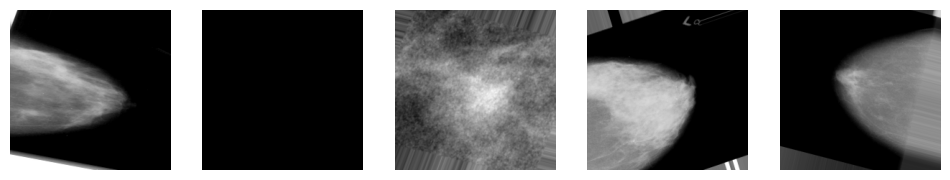

In [ ]:
# Define the base directory for CBIS-DDSM dataset
cbisdsm_base_dir = 'CBIS-DDSM'

# Get all image file paths from the extracted CBIS-DDSM directory
cbis_ddsm_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(cbisdsm_base_dir) for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Remove duplicate images
cbis_ddsm_image_paths = remove_duplicates(cbis_ddsm_image_paths)

# Load and preprocess the images
cbis_ddsm_images = load_and_preprocess_images(cbis_ddsm_image_paths)

print(f'Total CBIS-DDSM images: {len(cbis_ddsm_images)}')

# Create the data generator for augmentation
cbis_ddsm_data_gen = data_gen.flow(cbis_ddsm_images, batch_size=32, shuffle=False)

# Function to visualize augmented images
def visualize_augmented_images(image_gen, num_images=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        batch = next(image_gen)
        plt.subplot(1, num_images, i+1)
        plt.imshow(batch[0])
        plt.axis('off')
    plt.show()

# Visualize augmented images from CBIS-DDSM dataset
visualize_augmented_images(cbis_ddsm_data_gen)


### Image Preprocessing, Augmentation, and Visualization in BreakHis Dataset
In this step, we collect and preprocess images from the BreakHis dataset, removing duplicates to ensure a clean dataset. The images are resized and normalized for consistency. A data generator is then used to apply augmentations, such as rotation and flipping, to enhance the diversity of the training set. Finally, we visualize some of the augmented images to verify that the augmentations are correctly applied.

Total BreakHis images: 7909


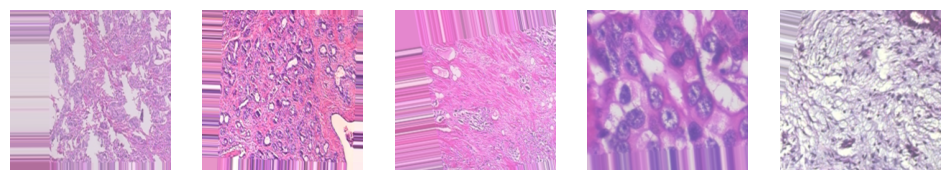

In [ ]:
import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

# Define the base directory for BreakHis dataset
breakhis_base_dir = '/content/drive/MyDrive/dataset/BreaKHis_v1/BreaKHis_v1'

# Get all image file paths from the extracted BreakHis directory
breakhis_image_paths = [os.path.join(root, file) for root, dirs, files in os.walk(breakhis_base_dir) for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Function to remove duplicate images
def remove_duplicates(image_paths):
    unique_paths = list(set(image_paths))
    return unique_paths

# Remove duplicate images
breakhis_image_paths = remove_duplicates(breakhis_image_paths)

# Function to load and preprocess images
def load_and_preprocess_images(image_paths, size=(224, 224)):
    images = []
    for path in image_paths:
        image = Image.open(path)
        image = image.resize(size)
        image = np.array(image) / 255.0  # Normalize to [0, 1]
        images.append(image)
    return np.array(images)

# Load and preprocess the images
breakhis_images = load_and_preprocess_images(breakhis_image_paths)

print(f'Total BreakHis images: {len(breakhis_images)}')

# Create the data generator for augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

breakhis_data_gen = data_gen.flow(breakhis_images, batch_size=32, shuffle=False)

# Function to visualize augmented images
def visualize_augmented_images(image_gen, num_images=5):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        batch = next(image_gen)
        plt.subplot(1, num_images, i+1)
        plt.imshow(batch[0])
        plt.axis('off')
    plt.show()

# Visualize augmented images from BreakHis dataset
visualize_augmented_images(breakhis_data_gen)


# Training Machine Learning Models

###Training Single Modality CNNs on BreakHis Dataset: Custom CNN (No Feature Engineering), ResNet, DenseNet
Here, we will train single-modality convolutional neural networks (CNNs) on the BreakHis dataset. We will include a custom CNN with no feature engineering, as well as ResNet and DenseNet models that automatically extract features as part of their architecture. The aim is to compare the performance of these models in classifying benign and malignant cases, understanding how the lack or presence of automated feature extraction impacts the results.


### Loading the BreakHis Dataset from Checkpoint
This step loads the preprocessed BreakHis images and labels from a saved checkpoint, enabling quick access to the dataset for model training. The number of images loaded is printed for verification.

In [ ]:
import pickle

# Load BreakHis dataset checkpoint
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'

with open(breakhis_checkpoint_path, 'rb') as file:
    breakhis_checkpoint = pickle.load(file)

breakhis_images = breakhis_checkpoint['breakhis_images']
breakhis_labels = breakhis_checkpoint['breakhis_labels']

print(f'Loaded BreakHis dataset from checkpoint with {breakhis_images.shape[0]} images.')


Loaded BreakHis dataset from checkpoint with 7909 images.


### Splitting BreakHis Data and Handling Class Imbalance
This step splits the BreakHis dataset into training (70%), validation (15%), and test (15%) sets, ensuring balanced class distribution using stratified sampling. Class weights are then calculated to address any class imbalance during model training. The class distributions and calculated class weights are printed for verification.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import numpy as np

# Assuming breakhis_images and breakhis_labels are already loaded
# Split BreakHis data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    breakhis_images, breakhis_labels, test_size=0.3, stratify=breakhis_labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Check the class distribution in each set
train_distribution = dict(zip(*np.unique(y_train, return_counts=True)))
val_distribution = dict(zip(*np.unique(y_val, return_counts=True)))
test_distribution = dict(zip(*np.unique(y_test, return_counts=True)))

print(f"Class distribution in training set: {train_distribution}")
print(f"Class distribution in validation set: {val_distribution}")
print(f"Class distribution in test set: {test_distribution}")

# Calculate class weights for handling class imbalance
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")



Class distribution in training set: {0: 1736, 1: 3800}
Class distribution in validation set: {0: 372, 1: 814}
Class distribution in test set: {0: 372, 1: 815}
Class Weights: {0: 1.5944700460829493, 1: 0.728421052631579}


### Training and Evaluating the Custom CNN Model on BreakHis Dataset
In this step, we define a custom CNN model and train it on the BreakHis dataset using class weights to handle class imbalance. The model is trained with early stopping to prevent overfitting, and its performance is evaluated on the validation set. The training process outputs validation loss and accuracy to assess the model's effectiveness in distinguishing between benign and malignant cases.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Define the custom CNN model
def build_custom_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate models with early stopping and class weights
def train_evaluate_model(model_builder, X_train, y_train, X_val, y_val, class_weights, n_epochs=10):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Initialize model
    model = model_builder(input_shape=X_train.shape[1:])

    # Train the model
    history = model.fit(X_train, y_train, epochs=n_epochs, validation_data=(X_val, y_val),
                        class_weight=class_weights, callbacks=[early_stopping], verbose=1)

    # Evaluate on validation data
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=1)
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return model, history

# Train the model on BreakHis dataset
model, history = train_evaluate_model(build_custom_cnn, X_train, y_train, X_val, y_val, class_weights, n_epochs=10)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.6710 - loss: 0.8072 - val_accuracy: 0.8238 - val_loss: 0.6516
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8083 - loss: 0.5107 - val_accuracy: 0.8415 - val_loss: 0.4399
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.7967 - loss: 0.4804 - val_accuracy: 0.8322 - val_loss: 0.4523
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8432 - loss: 0.4226 - val_accuracy: 0.7546 - val_loss: 0.6158
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8392 - loss: 0.4252 - val_accuracy: 0.7723 - val_loss: 0.4891
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8491 - loss: 0.4206 - val_accuracy: 0.8179 - val_loss: 0.4311
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8386 - loss: 0.3948 - val_accuracy: 0.8010 - val_loss: 0.4526
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8501 - loss: 0.3838 - val_accu

# Saving the Trained Custom CNN Model
The trained custom CNN model is saved to a specified path for future use. This allows for easy reloading and deployment of the model without the need to retrain it. The path where the model is saved is printed for confirmation.

In [ ]:
from tensorflow.keras.models import save_model

# Define the path where the model will be saved
model_save_path = '/content/drive/MyDrive/dataset/breakhis_baseline_model.keras'

# Save the trained model
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/dataset/breakhis_baseline_model.keras


### Making Predictions and Evaluating Model Performance
The trained custom CNN model is used to make predictions on the test set. The predicted probabilities are converted into binary class labels, and several key performance metrics are calculated: accuracy, precision, recall, F1 score, ROC AUC, and Matthews correlation coefficient (MCC). These metrics provide a comprehensive evaluation of the model's performance in distinguishing between benign and malignant cases. The results are printed to summarize the model's effectiveness.

In [ ]:

#  Load the model and make predictions
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

#  Calculate metrics
accuracy, precision, recall, f1, roc_auc, mcc = calculate_metrics(y_test, y_pred_classes, y_pred)

#  Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'MCC: {mcc:.4f}')




38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Accuracy: 0.8138
Precision: 0.9068
Recall: 0.8123
F1-Score: 0.8570
ROC-AUC: 0.8914
MCC: 0.6001
Accuracy: 0.8138
Precision: 0.9068
Recall: 0.8123
F1 Score: 0.8570
ROC AUC: 0.8914
MCC: 0.6001


### Visualizing Model Performance: Training Metrics, Confusion Matrix, and ROC Curve
we then visualize the performance of the trained custom CNN model on the BreakHis dataset. Two key visualizations are produced:

Training and Validation Metrics: We plot the accuracy and loss curves for both the training and validation sets over the epochs, providing insights into the model's learning process and potential overfitting.

Confusion Matrix and ROC Curve: The confusion matrix displays the breakdown of true positives, true negatives, false positives, and false negatives, while the ROC curve illustrates the trade-off between sensitivity and specificity. These plots help assess the model's classification performance and overall predictive capability.

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


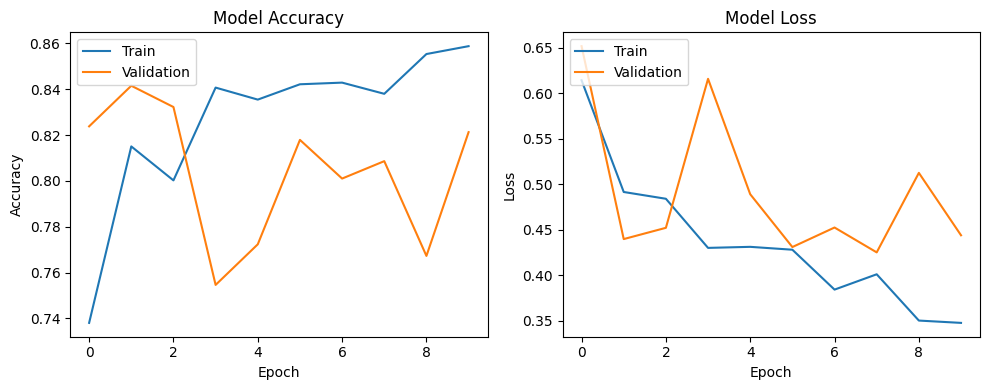

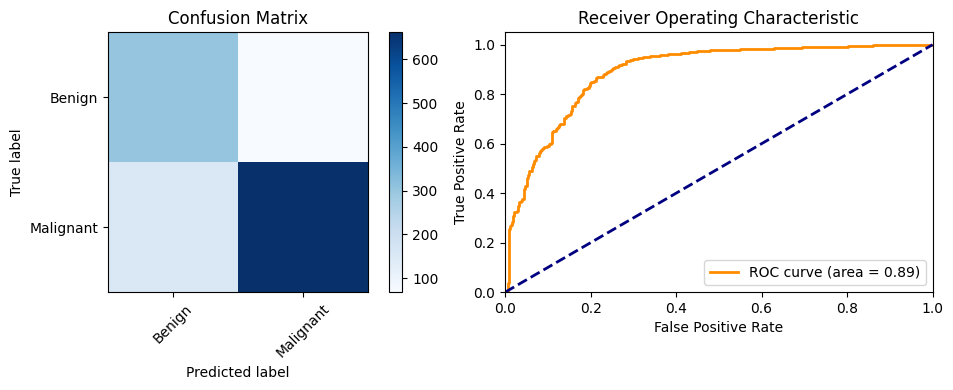

In [ ]:
# Assuming X_test and y_test are defined and available
y_pred_proba = model.predict(X_test)  # Predicted probabilities
y_pred_classes = (y_pred_proba > 0.5).astype("int32")  # Predicted classes

# Function to plot accuracy and loss curves
def plot_metrics(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix and ROC curve side by side
def plot_confusion_matrix(y_test, y_pred_classes, y_pred_proba):
    plt.figure(figsize=(10, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot the training process metrics
plot_metrics(history)

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(y_test, y_pred_classes, y_pred_proba)



### Training ResNet50 on BreakHis Dataset with Custom Layers
Here, we utilize the ResNet50 model pre-trained on ImageNet and fine-tune it for the BreakHis dataset by adding custom layers on top. The base ResNet50 layers are frozen to retain the learned features from ImageNet, while the custom layers are trained on the BreakHis data. The model is then compiled and trained with class weights to address class imbalance. The training is set for 10 epochs, with validation performed to monitor the model's performance throughout the training process.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of ResNet50
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
resnet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of ResNet50 except the custom layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the ResNet50 model
history_resnet = resnet_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.4680 - loss: 3.3316 - val_accuracy: 0.3137 - val_loss: 0.6945
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3847 - loss: 0.7015 - val_accuracy: 0.3137 - val_loss: 0.6948
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3223 - loss: 0.6983 - val_accuracy: 0.3137 - val_loss: 0.6943
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.4526 - loss: 0.6890 - val_accuracy: 0.3137 - val_loss: 0.6938
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.3287 - loss: 0.7022 - val_accuracy: 0.3137 - val_loss: 0.6940
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6102 - loss: 0.6864 - val_accuracy: 0.3137 - val_loss: 0.6932
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5495 - loss: 0.6904 - val_accuracy: 0.3137 - val_loss: 0.6932
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 24

### Saving the Trained ResNet50 Model
This step involves saving the trained ResNet50 model to a specified location in .keras format. This ensures that the model can be easily reloaded for future evaluations or deployment without the need to retrain it. The save operation is confirmed with a success message.

In [ ]:
# Save ResNet50 model before evaluation
resnet_model.save('/content/drive/MyDrive/dataset/resnet50_breakhis_model.keras')
print("ResNet50 model saved successfully in .keras format.")


ResNet50 model saved successfully in .keras format.


### Evaluating ResNet50 Model Performance Using Metrics Function
 we use a custom function to calculate key performance metrics for the ResNet50 model on the test set. The metrics calculated include accuracy, precision, recall, F1 score, ROC AUC, and Matthews correlation coefficient (MCC). These metrics provide a comprehensive assessment of the model's performance in classifying benign and malignant cases. The results are then printed to summarize the effectiveness of the ResNet50 model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

def calculate_metrics(y_true, y_pred_classes, y_pred_proba):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_classes)

    # Calculate precision
    precision = precision_score(y_true, y_pred_classes)

    # Calculate recall
    recall = recall_score(y_true, y_pred_classes)

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred_classes)

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Calculate Matthews correlation coefficient
    mcc = matthews_corrcoef(y_true, y_pred_classes)

    return accuracy, precision, recall, f1, roc_auc, mcc



In [ ]:
# Calculate metrics for ResNet50
accuracy_resnet, precision_resnet, recall_resnet, f1_resnet, roc_auc_resnet, mcc_resnet = calculate_metrics(y_test, y_pred_classes_resnet, y_pred_proba_resnet)

# Print metrics for ResNet50
print(f'ResNet50 - Accuracy: {accuracy_resnet:.4f}')
print(f'ResNet50 - Precision: {precision_resnet:.4f}')
print(f'ResNet50 - Recall: {recall_resnet:.4f}')
print(f'ResNet50 - F1 Score: {f1_resnet:.4f}')
print(f'ResNet50 - ROC AUC: {roc_auc_resnet:.4f}')
print(f'ResNet50 - MCC: {mcc_resnet:.4f}')


ResNet50 - Accuracy: 0.6866
ResNet50 - Precision: 0.6866
ResNet50 - Recall: 1.0000
ResNet50 - F1 Score: 0.8142
ResNet50 - ROC AUC: 0.5000
ResNet50 - MCC: 0.0000


Visualizing ResNet50 Performance: Metrics, Confusion Matrix, and ROC Curve

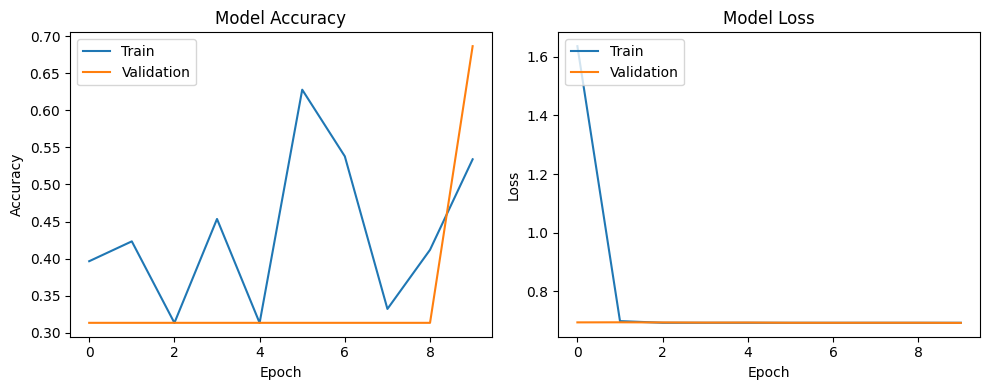

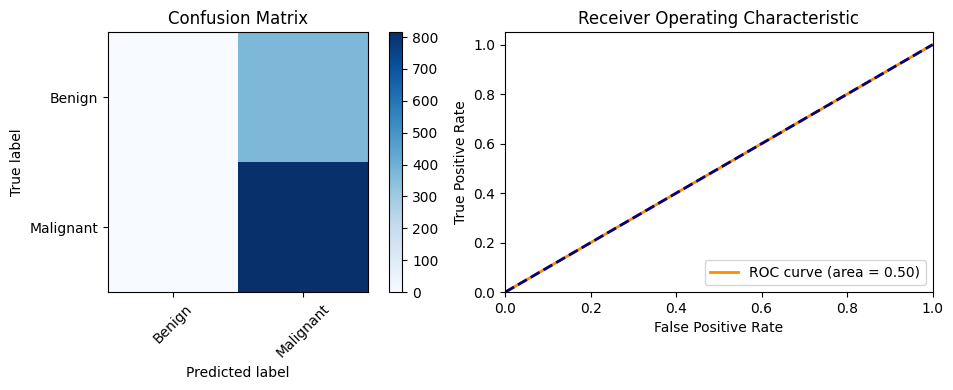

In [ ]:
# Plot the training process metrics
plot_metrics(history_resnet)

# Plot the confusion matrix and ROC curve for ResNet
plot_confusion_matrix(y_test, y_pred_classes_resnet, y_pred_proba_resnet)


Training DenseNet121 on BreakHis Dataset
we train a DenseNet121 model, pre-trained on ImageNet, with additional custom layers on the BreakHis dataset. The base DenseNet121 layers are frozen to retain pre-learned features, while only the custom layers are trained. The model is compiled and trained over 10 epochs, using class weights to handle any class imbalance. Validation is performed to monitor the model's performance throughout the training process.

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pre-trained on ImageNet
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of DenseNet121
x = base_model_densenet.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
densenet_model = Model(inputs=base_model_densenet.input, outputs=predictions)

# Freeze the layers of DenseNet121 except the custom layers
for layer in base_model_densenet.layers:
    layer.trainable = False

# Compile the model
densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the DenseNet121 model
history_densenet = densenet_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    class_weight=class_weights
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.5693 - loss: 4.2066 - val_accuracy: 0.7032 - val_loss: 0.5974
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6915 - loss: 0.7186 - val_accuracy: 0.8221 - val_loss: 0.4685
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7691 - loss: 0.5113 - val_accuracy: 0.7251 - val_loss: 0.5195
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7761 - loss: 0.4624 - val_accuracy: 0.7614 - val_loss: 0.4857
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8169 - loss: 0.3925 - val_accuracy: 0.8465 - val_loss: 0.3653
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8533 - loss: 0.3510 - val_accuracy: 0.8592 - val_loss: 0.3207
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8524 - loss: 0.3428 - val_accuracy: 0.8727 - val_loss: 0.3218
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 2

### Saving the Trained DenseNet121 Model
In this step, the trained DenseNet121 model is saved in .keras format to a specified location. This ensures the model can be easily reloaded for future evaluation or deployment.

In [ ]:
# Save DenseNet121 model before evaluation
densenet_model.save('/content/drive/MyDrive/dataset/densenet121_breakhis_model.keras')
print("DenseNet121 model saved successfully in .keras format.")


DenseNet121 model saved successfully in .keras format.


### Evaluating DenseNet121 Model Performance
we evaluate the DenseNet121 model on the test set by calculating key metrics: accuracy, precision, recall, F1 score, ROC AUC, and Matthews correlation coefficient (MCC). These metrics provide a detailed assessment of the model's performance in classifying the test data. The results are printed to summarize the DenseNet121 model's effectiveness.

In [ ]:
# Assuming X_test and y_test are defined and available
y_pred_proba_densenet = densenet_model.predict(X_test)  # Predicted probabilities
y_pred_classes_densenet = (y_pred_proba_densenet > 0.5).astype("int32")  # Predicted classes

# Calculate metrics for DenseNet
accuracy_densenet, precision_densenet, recall_densenet, f1_densenet, roc_auc_densenet, mcc_densenet = calculate_metrics(y_test, y_pred_classes_densenet, y_pred_proba_densenet)

# Print metrics for DenseNet
print(f'DenseNet - Accuracy: {accuracy_densenet:.4f}')
print(f'DenseNet - Precision: {precision_densenet:.4f}')
print(f'DenseNet - Recall: {recall_densenet:.4f}')
print(f'DenseNet - F1 Score: {f1_densenet:.4f}')
print(f'DenseNet - ROC AUC: {roc_auc_densenet:.4f}')
print(f'DenseNet - MCC: {mcc_densenet:.4f}')


38/38 ━━━━━━━━━━━━━━━━━━━━ 21s 318ms/step
DenseNet - Accuracy: 0.8703
DenseNet - Precision: 0.9413
DenseNet - Recall: 0.8650
DenseNet - F1 Score: 0.9015
DenseNet - ROC AUC: 0.9448
DenseNet - MCC: 0.7179


Visualizing DenseNet121 Performance: Metrics, Confusion Matrix, and ROC Curve

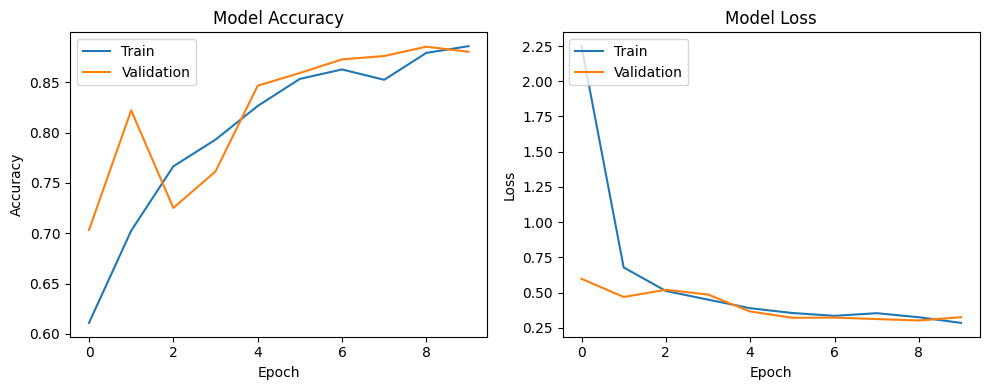

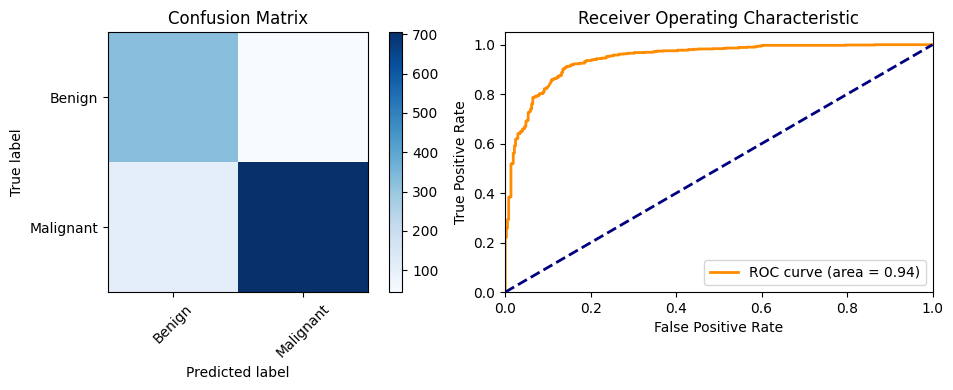

In [ ]:
# Plot the training process metrics for DenseNet
plot_metrics(history_densenet)

# Plot the confusion matrix and ROC curve for DenseNet
plot_confusion_matrix(y_test, y_pred_classes_densenet, y_pred_proba_densenet)


# Training Single Modality Traditional Machine Learning Models with Feature Engineering on BreakHis Dataset: SVM and Random Forest
In this step, we will focus on training single-modality traditional machine learning models—Support Vector Machine (SVM) and Random Forest—on the BreakHis dataset. Feature engineering will be applied to extract relevant features from the images, which will then be used to train these models. The objective is to assess how well these traditional approaches, when combined with engineered features, can classify benign and malignant cases compared to more complex deep learning models.                                                                                                                      

In [ ]:
!pip install mahotas  # Install the mahotas library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 18.5 MB/s eta 0:00:00


### Loading BreakHis Dataset for Traditional Machine Learning Models
 we load the BreakHis dataset, including images and labels, from a saved checkpoint. This dataset will be used to extract features for training traditional machine learning models, specifically SVM and Random Forest. The number of images loaded is confirmed to ensure the dataset is ready for feature extraction and subsequent model training.

In [ ]:
import pickle

# Load BreakHis dataset checkpoint
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'
with open(breakhis_checkpoint_path, 'rb') as file:
    breakhis_checkpoint = pickle.load(file)

breakhis_images = breakhis_checkpoint['breakhis_images']
breakhis_labels = breakhis_checkpoint['breakhis_labels']
print(f'Loaded BreakHis dataset from checkpoint with {breakhis_images.shape[0]} images.')

Loaded BreakHis dataset from checkpoint with 7909 images.


### Feature Engineering: Extracting Image Features for SVM and Random Forest
 we focus on feature engineering by extracting various features from the BreakHis dataset images to train traditional machine learning models, specifically SVM and Random Forest. We extract GLCM features to capture texture by analyzing gray-level co-occurrence matrices, HOG features to gather edges and gradient information, LBP features to describe texture through local binary patterns, and color histogram features to represent the color distribution within the images. These diverse features are then combined into a single feature vector for each image, providing a rich set of inputs for the SVM and Random Forest models. This process highlights the critical role of feature engineering in traditional machine learning, enabling the models to effectively classify benign and malignant cases in the dataset.

In [ ]:
import numpy as np
import mahotas
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage.color import rgb2gray

# Function to extract GLCM features
def extract_glcm_features(image):
    image_uint8 = (image * 255).astype(np.uint8)  # Convert float64 image to uint8
    gray_image = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)
    glcm = mahotas.features.haralick(gray_image).mean(axis=0)
    return glcm

# Function to extract HOG features
def extract_hog_features(image):
    gray_image = rgb2gray(image)
    hog_features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
    return hog_features

# Function to extract LBP features
def extract_lbp_features(image):
    image_uint8 = (image * 255).astype(np.uint8)  # Convert float64 image to uint8
    gray_image = rgb2gray(image_uint8)
    lbp = local_binary_pattern(gray_image, P=8, R=1, method="uniform")
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)  # Normalize the histogram
    return lbp_hist

# Function to extract color histogram features
def extract_color_histogram_features(image, bins=(8, 8, 8)):
    image_uint8 = (image * 255).astype(np.uint8)  # Convert float64 image to uint8
    hist = cv2.calcHist([image_uint8], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Combine all feature extraction methods into one
def extract_all_features(image):
    glcm_features = extract_glcm_features(image)
    hog_features = extract_hog_features(image)
    lbp_features = extract_lbp_features(image)
    color_histogram_features = extract_color_histogram_features(image)

    # Concatenate all features into a single feature vector
    return np.hstack([glcm_features, hog_features, lbp_features, color_histogram_features])




### Extracting Features for BreakHis Dataset
In this step, we extract the combined feature vectors for each image in the BreakHis dataset using the previously defined feature extraction methods. These features include GLCM, HOG, LBP, and color histogram information. The extracted features are stored in an array, providing a comprehensive representation of each image. The shape of the resulting feature array is printed to verify the successful extraction of features, which will be used as input for training the SVM and Random Forest models.

In [ ]:

# Using breakhis_images as image dataset
breakhis_features = []

for image in breakhis_images:
    features = extract_all_features(image)
    breakhis_features.append(features)

breakhis_features = np.array(breakhis_features)



In [ ]:
print(f"Feature array shape: {breakhis_features.shape}")


Feature array shape: (7909, 26778)


### Saving Extracted Features and Labels Checkpoint
In this step, we save the extracted features and corresponding labels from the BreakHis dataset into a checkpoint file using pickle. This allows for easy reloading of the processed data for future analysis or model training, without the need to re-extract the features. The path where the checkpoint is saved is printed to confirm the successful storage of the features and labels.

In [ ]:
import pickle

# Define the path for saving the features
features_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_features_checkpoint.pkl'

# Create a dictionary to store the features and labels
features_checkpoint = {
    'breakhis_features': breakhis_features,
    'breakhis_labels': breakhis_labels,
}

# Save the dictionary to a pickle file
with open(features_checkpoint_path, 'wb') as file:
    pickle.dump(features_checkpoint, file)

print(f"Features and labels checkpoint saved to {features_checkpoint_path}")


Features and labels checkpoint saved to /content/drive/MyDrive/dataset/breakhis_features_checkpoint.pkl


### Splitting BreakHis Features into Training, Validation, and Test Sets
 we load the extracted features and labels from the BreakHis dataset and split them into training (70%), validation (15%), and test (15%) sets. Stratified sampling is used to maintain the class distribution across all sets, ensuring that each subset represents the overall dataset's balance between benign and malignant cases. The class distribution in each set is printed to verify the stratification, ensuring that the splits are appropriate for training and evaluating the SVM and Random Forest models.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pickle

# Load the features and labels from the checkpoint
features_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_features_checkpoint.pkl'
with open(features_checkpoint_path, 'rb') as file:
    features_checkpoint = pickle.load(file)

breakhis_features = features_checkpoint['breakhis_features']
breakhis_labels = features_checkpoint['breakhis_labels']

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    breakhis_features, breakhis_labels, test_size=0.3, stratify=breakhis_labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Check the class distribution in each set
train_distribution = dict(zip(*np.unique(y_train, return_counts=True)))
val_distribution = dict(zip(*np.unique(y_val, return_counts=True)))
test_distribution = dict(zip(*np.unique(y_test, return_counts=True)))

print(f"Class distribution in training set: {train_distribution}")
print(f"Class distribution in validation set: {val_distribution}")
print(f"Class distribution in test set: {test_distribution}")


Class distribution in training set: {0: 1736, 1: 3800}
Class distribution in validation set: {0: 372, 1: 814}
Class distribution in test set: {0: 372, 1: 815}


### Feature Selection and Dimensionality Reduction for BreakHis Dataset
In this step, we perform feature selection and dimensionality reduction on the extracted features from the BreakHis dataset:

Feature Scaling: The features are scaled using StandardScaler to standardize the data, which is essential for the performance of many machine learning models.

Mutual Information Analysis: We compute mutual information between features and labels to identify the most relevant features for classification. The top features based on mutual information are selected to reduce the feature set while retaining important information.

Principal Component Analysis (PCA): Further dimensionality reduction is achieved by applying PCA to the selected features. This step helps in reducing the complexity of the dataset while retaining the variance, making the data more manageable and improving the efficiency of traditional machine learning models like SVM and Random Forest.

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

#  Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#  Mutual Information Analysis
mutual_info = mutual_info_classif(X_train_scaled, y_train)
mutual_info_sorted_indices = np.argsort(mutual_info)[::-1]

# Select top features based on mutual information
top_k_features = 500
X_train_mi = X_train_scaled[:, mutual_info_sorted_indices[:top_k_features]]
X_val_mi = X_val_scaled[:, mutual_info_sorted_indices[:top_k_features]]
X_test_mi = X_test_scaled[:, mutual_info_sorted_indices[:top_k_features]]

#  Principal Component Analysis (PCA)
# Apply PCA to reduce dimensionality further
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_mi)
X_val_pca = pca.transform(X_val_mi)
X_test_pca = pca.transform(X_test_mi)









### Saving Feature Selection and Dimensionality Reduction Checkpoint
 we save the processed features and labels, along with the associated scaling and PCA models, into a checkpoint file using pickle. This allows for easy reloading of the processed data and models for future use, ensuring that the feature selection and dimensionality reduction steps do not need to be repeated. The path where the checkpoint is saved is printed for confirmation.

In [ ]:
import pickle

# Define the checkpoint file path
feature_selection_checkpoint_path = '/content/drive/MyDrive/dataset/feature_selection_checkpoint.pkl'

# Create a dictionary to store the processed features and labels
feature_selection_checkpoint = {
    'X_train_pca': X_train_pca,
    'X_val_pca': X_val_pca,
    'X_test_pca': X_test_pca,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test,
    'scaler': scaler,
    'pca': pca,
    'mutual_info_sorted_indices': mutual_info_sorted_indices
}

# Save the dictionary to a pickle file
with open(feature_selection_checkpoint_path, 'wb') as file:
    pickle.dump(feature_selection_checkpoint, file)

print(f"Feature selection and dimensionality reduction checkpoint saved to {feature_selection_checkpoint_path}")


Feature selection and dimensionality reduction checkpoint saved to /content/drive/MyDrive/dataset/feature_selection_checkpoint.pkl


# Training the SVM Model on the Reduced Feature Set
In this step, we train a Support Vector Machine (SVM) model using the reduced feature set obtained from mutual information analysis and PCA. The SVM is configured with a linear kernel and is trained on the processed training data. This model will be used to classify the images in the BreakHis dataset, with the goal of distinguishing between benign and malignant cases based on the selected features.

In [ ]:
#  Train the models using the reduced feature set
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Train the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_pca, y_train)




SVC(kernel='linear', probability=True, random_state=42)

### Training the Random Forest Model on the Reduced Feature Set
 we train a Random Forest model using the PCA-reduced feature set. Configured with 100 estimators, the model is trained on the processed data to classify images in the BreakHis dataset.

In [ ]:


# train the Random Forest model using PCA-reduced features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

print("Random Forest model has been retrained successfully.")




Random Forest model has been retrained successfully.


# Saving the Trained Models to a Checkpoint
we save the trained models for future use. The SVM and Random Forest models are serialized and stored in pickle files for easy retrieval and deployment later.

In [ ]:
import pickle

# Define paths for saving the models
svm_model_path = '/content/drive/MyDrive/dataset/svm_model.pkl'
rf_model_path = '/content/drive/MyDrive/dataset/rf_model.pkl'


# Save the SVM model
with open(svm_model_path, 'wb') as file:
    pickle.dump(svm_model, file)
print(f"SVM model saved to {svm_model_path}")

# Save the Random Forest model
with open(rf_model_path, 'wb') as file:
    pickle.dump(rf_model, file)
print(f"Random Forest model saved to {rf_model_path}")




SVM model saved to /content/drive/MyDrive/dataset/svm_model.pkl
Random Forest model saved to /content/drive/MyDrive/dataset/rf_model.pkl


### Evaluating the Traditional  Models Performance: Metrics, Confusion Matrix, and ROC Curve
we define functions to evaluate the performance of our models:

Evaluate Model: This function calculates and prints key metrics including accuracy, precision, recall, F1 score, ROC AUC, and Matthews correlation coefficient (MCC). These metrics provide a comprehensive assessment of the model's effectiveness in classifying the test data.

Plot Evaluation: This function visualizes the model's performance through a confusion matrix and ROC curve. The confusion matrix shows the breakdown of true vs. predicted labels, helping to identify where the model may be making errors. The ROC curve illustrates the trade-off between sensitivity and specificity, providing insights into the model's discriminatory power.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Function to calculate and print metrics
def evaluate_model(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'MCC: {mcc:.4f}')

# Function to plot confusion matrix and ROC curve
def plot_evaluation(y_true, y_pred, y_pred_proba):
    plt.figure(figsize=(10, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()



### Evaluating and plotting  each model

SVM Evaluation:
Accuracy: 0.8568
Precision: 0.8595
Recall: 0.9460
F1 Score: 0.9007
ROC AUC: 0.8892
MCC: 0.6556


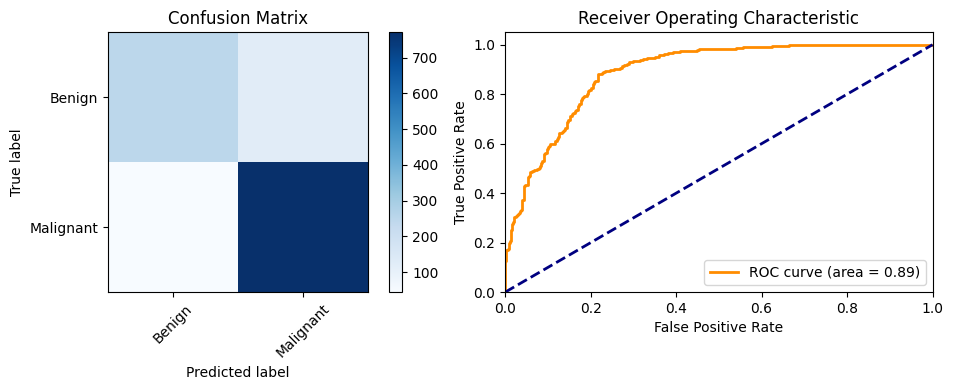


Random Forest Evaluation:
Accuracy: 0.8635
Precision: 0.8608
Recall: 0.9558
F1 Score: 0.9058
ROC AUC: 0.9048
MCC: 0.6726


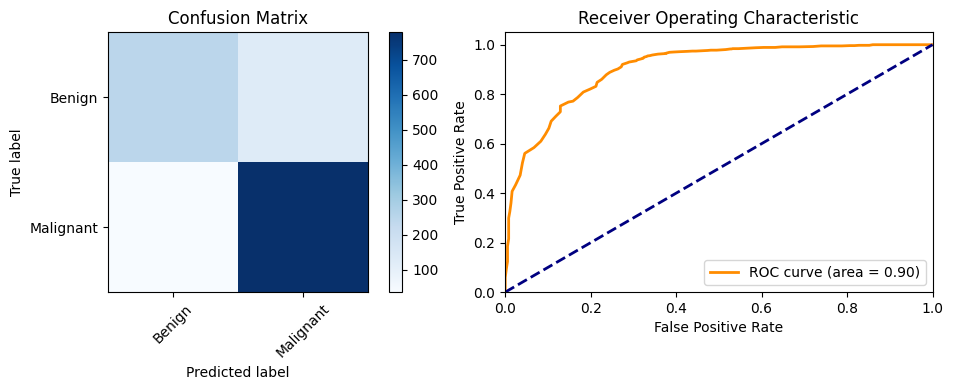

In [ ]:
# SVM Evaluation using PCA-reduced features
y_pred_svm = svm_model.predict(X_test_pca)
y_pred_proba_svm = svm_model.predict_proba(X_test_pca)[:, 1]

print("SVM Evaluation:")
evaluate_model(y_test, y_pred_svm, y_pred_proba_svm)
plot_evaluation(y_test, y_pred_svm, y_pred_proba_svm)

# Random Forest Evaluation using PCA-reduced features
y_pred_rf = rf_model.predict(X_test_pca)
y_pred_proba_rf = rf_model.predict_proba(X_test_pca)[:, 1]

print("\nRandom Forest Evaluation:")
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf)
plot_evaluation(y_test, y_pred_rf, y_pred_proba_rf)




### Training Single Modality Traditional Machine Learning Models Without Feature Engineering on BreakHis Dataset: SVM and Random Forest
we will train traditional machine learning models—Support Vector Machine (SVM) and Random Forest—on the BreakHis dataset without applying any feature engineering. Instead of extracting and selecting features, we will use the raw image data directly to evaluate how well these models can classify benign and malignant cases. This approach will allow us to compare the effectiveness of traditional machine learning models when used without feature engineering versus when features are carefully selected and engineered..

### Loading BreakHis Dataset for Traditional Machine Learning Without Feature Engineering
 we load the BreakHis dataset, including raw images and labels, from a saved checkpoint. This dataset will be used directly, without any feature engineering, for training the SVM and Random Forest models. The number of images loaded is confirmed to ensure the dataset is ready for model training.








In [ ]:
import pickle

# Load BreakHis dataset checkpoint
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'
with open(breakhis_checkpoint_path, 'rb') as file:
    breakhis_checkpoint = pickle.load(file)

breakhis_images = breakhis_checkpoint['breakhis_images']
breakhis_labels = breakhis_checkpoint['breakhis_labels']
print(f'Loaded BreakHis dataset from checkpoint with {breakhis_images.shape[0]} images.')


Loaded BreakHis dataset from checkpoint with 7909 images.


### Splitting BreakHis Dataset Without Feature Engineering
 we split the BreakHis dataset into training (70%), validation (15%), and test (15%) sets using the raw image data, without any feature engineering. Stratified sampling is applied to maintain the class distribution across the splits, ensuring that each subset accurately represents the benign and malignant cases. The class distribution in each set is printed to verify the stratification, ensuring balanced representation in the training, validation, and test sets for subsequent model training and evaluation.

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    breakhis_images, breakhis_labels, test_size=0.3, stratify=breakhis_labels, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Check the class distribution in each set
train_distribution = dict(zip(*np.unique(y_train, return_counts=True)))
val_distribution = dict(zip(*np.unique(y_val, return_counts=True)))
test_distribution = dict(zip(*np.unique(y_test, return_counts=True)))

print(f"Class distribution in training set: {train_distribution}")
print(f"Class distribution in validation set: {val_distribution}")
print(f"Class distribution in test set: {test_distribution}")


Class distribution in training set: {0: 1736, 1: 3800}
Class distribution in validation set: {0: 372, 1: 814}
Class distribution in test set: {0: 372, 1: 815}


### Minimal Preprocessing: Flattening and Scaling Raw Image Data for Model Input
 we apply minimal preprocessing—flattening the images and scaling the data—to prepare the raw image data for input into traditional machine learning models like SVM and Random Forest. This is necessary to convert the 3D image data into a format suitable for these models, without performing extensive feature engineering.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_val_scaled = scaler.transform(X_val_flat)
X_test_scaled = scaler.transform(X_test_flat)


### Training SVM and Random Forest Models on Raw Image Data
 we train traditional machine learning models—Support Vector Machine (SVM) and Random Forest—using the minimally preprocessed (flattened and scaled) raw image data from the BreakHis dataset. The SVM is configured with a linear kernel, and the Random Forest is set with 100 estimators.

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Train the SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [ ]:
# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

print("Models have been trained successfully.")

Models have been trained successfully.


### Saving Trained SVM and Random Forest Models
we save the trained SVM and Random Forest models to specified file paths using pickle. This ensures that the models can be easily reloaded for future evaluation or comparison, particularly in the context of assessing the impact of feature engineering. The save operation is confirmed with a success message for each model.

In [ ]:
import pickle

# Define paths for saving the models
svm_model_path = '/content/drive/MyDrive/dataset/svm_model_comparison2.pkl'
# Save the SVM model
with open(svm_model_path, 'wb') as file:
    pickle.dump(svm_model, file)
print(f"SVM model saved to {svm_model_path}")

SVM model saved to /content/drive/MyDrive/dataset/svm_model_comparison2.pkl


In [ ]:
import pickle
rf_model_path = '/content/drive/MyDrive/dataset/rf_model_comparison2.pkl'
# Save the Random Forest model
with open(rf_model_path, 'wb') as file:
    pickle.dump(rf_model, file)
print(f"Random Forest model saved to {rf_model_path}")

Random Forest model saved to /content/drive/MyDrive/dataset/rf_model_comparison2.pkl


### Evaluating SVM and Random Forest Models on Raw, Scaled Features
This step evaluates the SVM and Random Forest models using raw, scaled features:

SVM Evaluation: Metrics and visualizations (confusion matrix and ROC curve) assess the model's performance.
Random Forest Evaluation: Similar metrics and visualizations are used to evaluate the Random Forest model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

# Function to calculate and print metrics
def evaluate_model(y_true, y_pred, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'MCC: {mcc:.4f}')

# Function to plot confusion matrix and ROC curve
def plot_evaluation(y_true, y_pred, y_pred_proba):
    plt.figure(figsize=(10, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()




SVM Evaluation:
Accuracy: 0.7995
Precision: 0.8398
Recall: 0.8748
F1 Score: 0.8570
ROC AUC: 0.8277
MCC: 0.5234


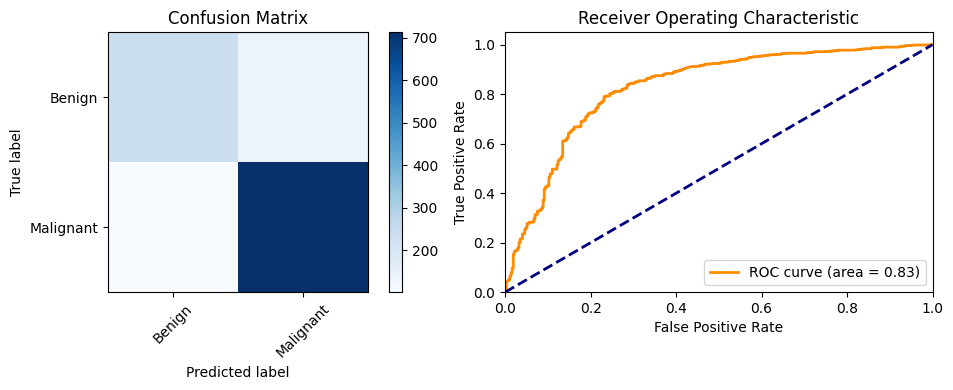


Random Forest Evaluation:
Accuracy: 0.8357
Precision: 0.8444
Recall: 0.9325
F1 Score: 0.8863
ROC AUC: 0.9052
MCC: 0.6026


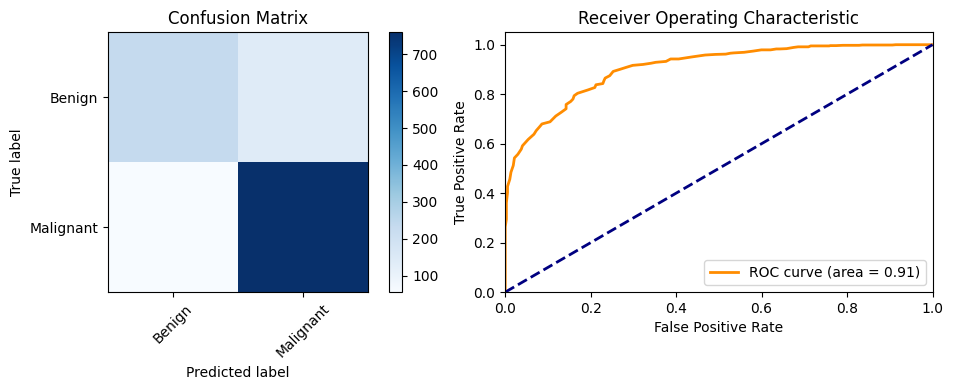

In [ ]:
# SVM Evaluation using raw, scaled features
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

print("SVM Evaluation:")
evaluate_model(y_test, y_pred_svm, y_pred_proba_svm)
plot_evaluation(y_test, y_pred_svm, y_pred_proba_svm)

# Random Forest Evaluation using raw, scaled features
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nRandom Forest Evaluation:")
evaluate_model(y_test, y_pred_rf, y_pred_proba_rf)
plot_evaluation(y_test, y_pred_rf, y_pred_proba_rf)

# Multimodal Model Training and Evaluation
### In this section, we will explore and train multimodal models that leverage dual input streams from different imaging modalities. By combining histopathological and mammographic images, we aim to enhance the performance of custom CNNs, ResNet, and DenseNet models. The goal is to evaluate how integrating multiple data sources can improve the accuracy and robustness of breast cancer diagnosis.

### Multimodal Models: Dual Input Streams from Histopathological and Mammographic Images Using Custom CNN (No Feature Engineering), ResNet, and DenseNet
 we will train multimodal models that combine histopathological images from the BreakHis dataset and mammographic images from the CBIS-DDSM dataset. The models include a custom CNN without feature engineering, and ResNet and DenseNet models that incorporate automated feature extraction as part of their architecture. By processing both imaging modalities simultaneously, these models aim to improve the classification of benign and malignant cases, leveraging the complementary information provided by the two different types of images.

## Filtering the CBIS-DDSM Dataset for Malignant and Benign Cases
 we filter the CBIS-DDSM dataset to include only cases labeled as 'malignant' or 'benign'. This ensures that the dataset used for training the multimodal models focuses exclusively on these two classes, which are essential for the binary classification task.

The filtered dataset is then verified by checking its shape and displaying the first few entries. This step ensures that only relevant cases are included in the subsequent model training processes.

In [ ]:
# Filter the DataFrame to include only 'malignant' or 'benign' cases
filtered_cbis_ddsm_df = cbis_ddsm_df[cbis_ddsm_df['pathology'].str.lower().isin(['malignant', 'benign'])]

# Verify the filtered DataFrame
print(f"Filtered CBIS-DDSM DataFrame Shape: {filtered_cbis_ddsm_df.shape}")
print("Filtered CBIS-DDSM DataFrame Head:")
print(filtered_cbis_ddsm_df.head())


Filtered CBIS-DDSM DataFrame Shape: (2886, 18)
Filtered CBIS-DDSM DataFrame Head:
   patient_id  breast density left or right breast image view  abnormality id  \
0     P_00005             3.0                RIGHT         CC               1   
1     P_00005             3.0                RIGHT        MLO               1   
2     P_00007             4.0                 LEFT         CC               1   
3     P_00007             4.0                 LEFT        MLO               1   
22    P_00011             3.0                 LEFT         CC               1   

   abnormality type    calc type calc distribution  assessment  pathology  \
0     calcification    AMORPHOUS         CLUSTERED           3  MALIGNANT   
1     calcification    AMORPHOUS         CLUSTERED           3  MALIGNANT   
2     calcification  PLEOMORPHIC            LINEAR           4     BENIGN   
3     calcification  PLEOMORPHIC            LINEAR           4     BENIGN   
22    calcification  PLEOMORPHIC         CLUST

### Loading and Filtering Multiple CBIS-DDSM CSV Files for Malignant and Benign Cases
Starting a new session  we load data from multiple CSV files within the CBIS-DDSM dataset, specifically focusing on cases labeled as 'benign' or 'malignant.' Each CSV file, corresponding to different subsets of the dataset (e.g., calcification and mass cases, both training and test sets), is loaded and filtered to include only these relevant cases. After filtering, the data from all CSV files is combined into a single DataFrame, consolidating the information for easier processing in the multimodal model training. This ensures that the dataset used in subsequent steps is focused on the binary classification task of distinguishing between benign and malignant cases.

In [ ]:
import pandas as pd

# Define the paths to the relevant CSV files
csv_files = [
    'csv/calc_case_description_train_set.csv',
    'csv/calc_case_description_test_set.csv',
    'csv/mass_case_description_train_set.csv',
    'csv/mass_case_description_test_set.csv'
]

# Load and filter the CSV files
filtered_dfs = []
for csv_file in csv_files:
    with ZipFile(zip_file_path, 'r') as zip_ref:
        with zip_ref.open(csv_file) as file:
            df = pd.read_csv(file)
            filtered_df = df[df['pathology'].str.lower().isin(['benign', 'malignant'])]
            filtered_dfs.append(filtered_df)

# Combine all filtered data into one DataFrame
combined_filtered_df = pd.concat(filtered_dfs, ignore_index=True)

# Verify the filtering
print(f"Total number of images with 'benign' or 'malignant' pathology: {len(combined_filtered_df)}")
combined_filtered_df.head()


Total number of images with 'benign' or 'malignant' pathology: 2886


patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005             3.0                RIGHT         CC               1   
1    P_00005             3.0                RIGHT        MLO               1   
2    P_00007             4.0                 LEFT         CC               1   
3    P_00007             4.0                 LEFT        MLO               1   
4    P_00011             3.0                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  pathology  \
0    calcification    AMORPHOUS         CLUSTERED           3  MALIGNANT   
1    calcification    AMORPHOUS         CLUSTERED           3  MALIGNANT   
2    calcification  PLEOMORPHIC            LINEAR           4     BENIGN   
3    calcification  PLEOMORPHIC            LINEAR           4     BENIGN   
4    calcification  PLEOMORPHIC         CLUSTERED           4     BENIGN   

   subtlety                                    image file path  \
0         3  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1         3  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2         4  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3         4  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4         1  Calc-Training_P_00011_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00011_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  breast_density  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...             NaN   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....             NaN   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...             NaN   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...             NaN   
4  Calc-Training_P_00011_LEFT_CC_1/1.3.6.1.4.1.95...             NaN   

  mass shape mass margins  
0        NaN          NaN  
1        NaN          NaN  
2        NaN          NaN  
3        NaN          NaN  
4        NaN          NaN

Comparing Sample Image Paths from ZIP Archive and Filtered DataFrame

In [ ]:
# Display a few sample paths from the DataFrame
print("Sample paths from the filtered DataFrame:")
print(combined_filtered_df['image file path'].head())


Sample paths from the filtered DataFrame:
0    Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...
1    Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...
2    Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...
3    Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...
4    Calc-Training_P_00011_LEFT_CC/1.3.6.1.4.1.9590...
Name: image file path, dtype: object


### Extracting Filtered CBIS-DDSM Images Based on Unique Identifiers
we extract relevant images from the CBIS-DDSM dataset based on unique identifiers from a filtered DataFrame. The images are extracted from a ZIP file and saved to a specified destination directory, ensuring that only those corresponding to 'benign' or 'malignant' cases are included. Unique filenames are generated to avoid conflicts, and the process is verified by counting and listing the extracted files. This streamlined approach ensures that only the necessary images are prepared for further analysis.


In [ ]:
import os
from zipfile import ZipFile

# Define the ZIP file path and destination directory
zip_file_path = '/content/drive/MyDrive/dataset/CBIS-DDSM.zip'
destination_dir = '/content/drive/MyDrive/dataset/Filtered_CBIS_DDSM_Images'

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Extract the unique identifiers from the filtered DataFrame
unique_identifiers = combined_filtered_df['image file path'].apply(lambda x: x.split('/')[-2]).unique()

# Extract and save images based on unique identifiers
with ZipFile(zip_file_path, 'r') as zip_ref:
    matched_files = 0
    for file in zip_ref.namelist():
        if any(identifier in file for identifier in unique_identifiers) and file.endswith('.jpg'):
            # Ensure a unique filename by including part of the directory structure
            subdir_name = os.path.basename(os.path.dirname(file))
            unique_filename = f"{subdir_name}_{os.path.basename(file)}"
            destination_path = os.path.join(destination_dir, unique_filename)

            # Extract the image to the destination directory
            with zip_ref.open(file) as source, open(destination_path, 'wb') as target:
                target.write(source.read())
            print(f"Extracted: {unique_filename}")
            matched_files += 1

print(f"Extraction complete. {matched_files} images saved to {destination_dir}")

# List and count only image files, excluding directories
extracted_images = [f for f in os.listdir(destination_dir) if os.path.isfile(os.path.join(destination_dir, f))]
print(f"Number of images extracted: {len(extracted_images)}")
if extracted_images:
    print(f"Sample of extracted images: {extracted_images[:5]}")
else:
    print("No images were extracted.")


Extracted: 1.3.6.1.4.1.9590.100.1.2.100131208110604806117271735422083351547_1-126.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100522099512256189513864912954167862869_1-231.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100522676511025180541602449080267145647_1-111.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100579676611077714807988832023693299884_1-108.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100631678311747240317898717702514834166_1-031.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100632214012866120117337678502539182046_1-075.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100682860911308271813943300011840547108_1-198.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100764250811134786606184452222065316702_1-030.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.100792511112769116642896236870187678269_1-014.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.101088347411683211841739390870264222457_1-048.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.101282442711963955211635160453427358442_1-072.jpg
Extracted: 1.3.6.1.4.1.9590.100.1.2.101582563912460219

# Review and Validate Extracted Images Against Pathology Labels

We start by listing all the extracted images in the destination directory and extracting their unique identifiers from the filenames. These identifiers are then matched against the original filtered DataFrame to ensure that all images correspond correctly to their 'benign' or 'malignant' labels. A merged DataFrame is created to verify the matches, and the number of successful matches is checked. Additionally, we check for any discrepancies, such as images that were extracted but not matched with the filtered data, ensuring the integrity of the extraction process.

In [ ]:
import os
import pandas as pd

# Define the destination directory where images were extracted
destination_dir = '/content/drive/MyDrive/dataset/Filtered_CBIS_DDSM_Images'

# List all extracted images in the directory
extracted_images = os.listdir(destination_dir)

# Extract the identifiers from the filenames in the destination directory
extracted_identifiers = [filename.split('_')[0] for filename in extracted_images if filename.endswith('.jpg')]

# Create a DataFrame for extracted images
extracted_df = pd.DataFrame({'identifier': extracted_identifiers, 'filename': extracted_images})

# Merge the extracted_df with the original combined_filtered_df to verify matches
# This will help you see if all the images correspond to the correct labels
merged_df = pd.merge(combined_filtered_df, extracted_df, left_on=combined_filtered_df['image file path'].apply(lambda x: x.split('/')[-2]), right_on='identifier', how='inner')

# Check the number of matches
print(f"Number of matches: {len(merged_df)} out of {len(extracted_images)} extracted images")

# Display a sample of the matches
print(merged_df[['pathology', 'image file path', 'filename']].head())

# Optional: Check for any discrepancies, i.e., images that were extracted but not matched
unmatched_images = [img for img in extracted_images if img.split('_')[0] not in extracted_identifiers]
if unmatched_images:
    print(f"Unmatched images: {len(unmatched_images)}")
    print("Sample of unmatched images:", unmatched_images[:5])
else:
    print("All extracted images match the expected cases.")


Number of matches: 2886 out of 2704 extracted images
   pathology                                    image file path  \
0  MALIGNANT  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  MALIGNANT  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2     BENIGN  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3     BENIGN  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4     BENIGN  Calc-Training_P_00011_LEFT_CC/1.3.6.1.4.1.9590...   

                                            filename  
0  1.3.6.1.4.1.9590.100.1.2.474143160103683865197...  
1  1.3.6.1.4.1.9590.100.1.2.250596608311207922527...  
2  1.3.6.1.4.1.9590.100.1.2.228699627313487111012...  
3  1.3.6.1.4.1.9590.100.1.2.104743410411133110629...  
4  1.3.6.1.4.1.9590.100.1.2.389208391412680785736...  
All extracted images match the expected cases.


### Saving Checkpoint for Filtered CBIS-DDSM Data
we save a checkpoint containing key data from the filtered CBIS-DDSM dataset. The checkpoint includes the merged DataFrame that verifies the correspondence between extracted images and their labels, the list of extracted images, and the path to the destination directory where these images are stored. This data is saved as a pickle file, ensuring that it can be easily reloaded for future analysis without needing to repeat the filtering and extraction processes.

In [ ]:
import os
import pickle



# Define the path to save the checkpoint
checkpoint_path = '/content/drive/MyDrive/dataset/filtered_cbis_ddsm_checkpoint.pkl'

# Create the checkpoint dictionary
checkpoint = {
    'merged_df': merged_df,
    'extracted_images': extracted_images,
    'destination_dir': destination_dir
}

# Save the checkpoint
with open(checkpoint_path, 'wb') as file:
    pickle.dump(checkpoint, file)

print(f"Checkpoint saved to {checkpoint_path}")


Checkpoint saved to /content/drive/MyDrive/dataset/filtered_cbis_ddsm_checkpoint.pkl


### Preprocessing CBIS-DDSM Images for Multimodal Model
 we preprocess images from the CBIS-DDSM dataset to prepare them for use in our multimodal model. Each image is converted to RGB, resized to 224x224 pixels, and normalized to a [0, 1] range to ensure consistency across the dataset. Corresponding labels are extracted and converted into a binary format, with 'malignant' labeled as 1 and 'benign' as 0. The preprocessed images and labels are stored in NumPy arrays, with their shapes verified to ensure correctness. This preprocessing standardizes the images, making them ready for input into the multimodal model.

In [ ]:
import numpy as np
from PIL import Image

# Function to preprocess images
def preprocess_image(image_path, size=(224, 224)):
    image = Image.open(image_path).convert('RGB')  # Convert grayscale to RGB
    image = image.resize(size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image





In [ ]:
# Extract image paths and labels from the merged DataFrame
cbis_ddsm_img_paths = merged_df['filename'].apply(lambda x: os.path.join(destination_dir, x)).tolist()
cbis_ddsm_img_labels = merged_df['pathology'].apply(lambda x: 1 if x.lower() == 'malignant' else 0).tolist()

preprocessed_cbis_ddsm_images = np.array([preprocess_image(img_path) for img_path in cbis_ddsm_img_paths])
preprocessed_cbis_ddsm_labels = np.array(cbis_ddsm_img_labels)

# Verify the shape of the images and labels again
print(f'Loaded {len(preprocessed_cbis_ddsm_images)} images from CBIS-DDSM dataset.')
print(f'CBIS-DDSM Images Shape: {preprocessed_cbis_ddsm_images.shape}')
print(f'CBIS-DDSM Labels Shape: {preprocessed_cbis_ddsm_labels.shape}')

Loaded 2886 images from CBIS-DDSM dataset.
CBIS-DDSM Images Shape: (2886, 224, 224, 3)
CBIS-DDSM Labels Shape: (2886,)


Saving Preprocessed CBIS-DDSM Data Checkpoint

In [ ]:
import pickle

# Define a new checkpoint file path to avoid overwriting the existing one
cbis_ddsm_checkpoint_path = '/content/drive/MyDrive/dataset/cbis_ddsm_preprocessed_checkpoint.pkl'

# Create a dictionary to store the CBIS-DDSM dataset
cbis_ddsm_checkpoint = {
    'cbis_ddsm_images': preprocessed_cbis_ddsm_images,
    'cbis_ddsm_labels': preprocessed_cbis_ddsm_labels,
    'cbis_ddsm_images_shape': preprocessed_cbis_ddsm_images.shape,
    'cbis_ddsm_labels_shape': preprocessed_cbis_ddsm_labels.shape
}

# Save the dictionary to a pickle file
with open(cbis_ddsm_checkpoint_path, 'wb') as file:
    pickle.dump(cbis_ddsm_checkpoint, file)

print(f"CBIS-DDSM checkpoint saved to {cbis_ddsm_checkpoint_path}")


CBIS-DDSM checkpoint saved to /content/drive/MyDrive/dataset/cbis_ddsm_preprocessed_checkpoint.pkl


### Loading BreakHis Dataset for Multimodal Approach
 we load the BreakHis dataset from a previously saved checkpoint. This dataset will be used alongside the CBIS-DDSM dataset in the multimodal approach. The BreakHis images and labels are extracted from the checkpoint file, and their shapes are verified to ensure that the data has been correctly loaded. This dataset will be paired with the CBIS-DDSM dataset to form the dual input streams required for training the multimodal models.

In [ ]:
import pickle

# Define the checkpoint file path for BreakHis dataset
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'

# Load the BreakHis dataset from the checkpoint
with open(breakhis_checkpoint_path, 'rb') as file:
    breakhis_checkpoint = pickle.load(file)

# Extract the images and labels from the checkpoint
breakhis_images = breakhis_checkpoint['breakhis_images']
breakhis_labels = breakhis_checkpoint['breakhis_labels']

# Verify the loaded data
print(f"Loaded {len(breakhis_images)} images from BreakHis checkpoint.")
print(f"BreakHis Images Shape: {breakhis_images.shape}")
print(f"BreakHis Labels Shape: {breakhis_labels.shape}")


Loaded 7909 images from BreakHis checkpoint.
BreakHis Images Shape: (7909, 224, 224, 3)
BreakHis Labels Shape: (7909,)


### Loading CBIS-DDSM Dataset for Multimodal Approach
 we load the preprocessed CBIS-DDSM dataset from a previously saved checkpoint. This dataset, which includes images and labels, will be used in conjunction with the BreakHis dataset for the multimodal approach. After loading the data, the number of images and their respective shapes are verified to ensure that everything has been correctly loaded. This dataset, along with the BreakHis dataset, will form the dual input streams necessary for training the multimodal models.

In [ ]:
import pickle

# Define the checkpoint file path for CBIS-DDSM dataset
cbis_ddsm_checkpoint_path = '/content/drive/MyDrive/dataset/cbis_ddsm_preprocessed_checkpoint.pkl'

# Load the CBIS-DDSM dataset from the checkpoint
with open(cbis_ddsm_checkpoint_path, 'rb') as file:
    cbis_ddsm_checkpoint = pickle.load(file)

# Extract the images and labels from the checkpoint
preprocessed_cbis_ddsm_images = cbis_ddsm_checkpoint['cbis_ddsm_images']
preprocessed_cbis_ddsm_labels = cbis_ddsm_checkpoint['cbis_ddsm_labels']

# Verify the loaded data
print(f"Loaded {len(preprocessed_cbis_ddsm_images)} images from CBIS-DDSM checkpoint.")
print(f"CBIS-DDSM Images Shape: {preprocessed_cbis_ddsm_images.shape}")
print(f"CBIS-DDSM Labels Shape: {preprocessed_cbis_ddsm_labels.shape}")


Loaded 2886 images from CBIS-DDSM checkpoint.
CBIS-DDSM Images Shape: (2886, 224, 224, 3)
CBIS-DDSM Labels Shape: (2886,)


### Building a Dual-Stream CNN for Multimodal Learning
we design a dual-stream CNN model for multimodal breast cancer diagnosis, using both histopathological images from the BreakHis dataset and mammographic images from the CBIS-DDSM dataset. The model consists of two parallel CNNs, each tailored to process one image modality. Each stream includes layers of convolution, max pooling, and dense connections, capturing detailed features from the images. The outputs from both streams are concatenated and passed through additional dense layers, with a final sigmoid output layer for binary classification. This approach leverages the complementary information from both image types, aiming to enhance diagnostic accuracy. The model is compiled with the Adam optimizer and binary cross-entropy loss, preparing it for training on the combined dataset.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the Custom CNN model used for each stream
def build_custom_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    return model

# Define the Dual-Stream CNN for multimodal learning
def build_dual_stream_cnn(input_shape):
    # First Stream (Histopathological Images - BreakHis)
    input_histopath = layers.Input(shape=input_shape)
    histopath_stream = build_custom_cnn(input_shape)(input_histopath)

    # Second Stream (Mammographic Images - CBIS-DDSM)
    input_mammo = layers.Input(shape=input_shape)
    mammo_stream = build_custom_cnn(input_shape)(input_mammo)

    # Combine both streams
    combined = layers.Concatenate()([histopath_stream, mammo_stream])
    combined = layers.Dense(128, activation='relu')(combined)
    combined = layers.Dropout(0.5)(combined)
    output = layers.Dense(1, activation='sigmoid')(combined)

    # Define the model
    model = models.Model(inputs=[input_histopath, input_mammo], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the dual-stream model
input_shape = (224, 224, 3)
dual_stream_cnn = build_dual_stream_cnn(input_shape)

# Print the model summary
dual_stream_cnn.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_10            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 128)            │     11,168,960 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_5 (Sequential) │ (None, 128)            │     11,168,960 │ input_layer_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256)            │              0 │ sequential_4[0][0],    │
│ (Concatenate)             │                        │                │ sequential_5[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 128)            │         32,896 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 128)            │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 1)              │            129 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 22,370,945 (85.34 MB)

 Trainable params: 22,370,945 (85.34 MB)

 Non-trainable params: 0 (0.00 B)

### Splitting the BreakHis and CBIS-DDSM Datasets for Multimodal Training
 we load the BreakHis and CBIS-DDSM datasets from their respective checkpoints and split them into training, validation, and test sets. For both datasets, we allocate 70% of the data to training, 15% to validation, and 15% to testing. Stratified sampling ensures that the class distribution remains balanced across all splits.

BreakHis Dataset: The histopathological images are split into training, validation, and test sets.
CBIS-DDSM Dataset: The mammographic images undergo the same splitting process.
The shapes of the resulting splits are printed to verify that the data has been correctly partitioned, ensuring that both modalities are properly prepared for training and evaluation in the multimodal model.

In [ ]:
import pickle
from sklearn.model_selection import train_test_split

# Load BreakHis dataset checkpoint
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'
with open(breakhis_checkpoint_path, 'rb') as file:
    breakhis_checkpoint = pickle.load(file)
breakhis_images = breakhis_checkpoint['breakhis_images']
breakhis_labels = breakhis_checkpoint['breakhis_labels']

print(f'Loaded BreakHis dataset from checkpoint with {breakhis_images.shape[0]} images.')

# Load the correct CBIS-DDSM checkpoint
cbis_ddsm_checkpoint_path = '/content/drive/MyDrive/dataset/cbis_ddsm_preprocessed_checkpoint.pkl'
with open(cbis_ddsm_checkpoint_path, 'rb') as file:
    cbis_ddsm_checkpoint = pickle.load(file)
cbis_ddsm_images = cbis_ddsm_checkpoint['cbis_ddsm_images']
cbis_ddsm_labels = cbis_ddsm_checkpoint['cbis_ddsm_labels']

print(f'Loaded CBIS-DDSM dataset from checkpoint with {cbis_ddsm_images.shape[0]} images.')

# Split BreakHis dataset into training (70%), validation (15%), and test (15%) sets
X_histopath_train, X_histopath_temp, y_histopath_train, y_histopath_temp = train_test_split(
    breakhis_images, breakhis_labels, test_size=0.3, stratify=breakhis_labels, random_state=42
)

X_histopath_val, X_histopath_test, y_histopath_val, y_histopath_test = train_test_split(
    X_histopath_temp, y_histopath_temp, test_size=0.5, stratify=y_histopath_temp, random_state=42
)

# Split CBIS-DDSM dataset into training (70%), validation (15%), and test (15%) sets
X_mammo_train, X_mammo_temp, y_mammo_train, y_mammo_temp = train_test_split(
    cbis_ddsm_images, cbis_ddsm_labels, test_size=0.3, stratify=cbis_ddsm_labels, random_state=42
)

X_mammo_val, X_mammo_test, y_mammo_val, y_mammo_test = train_test_split(
    X_mammo_temp, y_mammo_temp, test_size=0.5, stratify=y_mammo_temp, random_state=42
)

# Verify the shape of the splits
print(f"Histopath Training Set Shape: {X_histopath_train.shape}, Labels: {y_histopath_train.shape}")
print(f"Histopath Validation Set Shape: {X_histopath_val.shape}, Labels: {y_histopath_val.shape}")
print(f"Histopath Test Set Shape: {X_histopath_test.shape}, Labels: {y_histopath_test.shape}")

print(f"Mammo Training Set Shape: {X_mammo_train.shape}, Labels: {y_mammo_train.shape}")
print(f"Mammo Validation Set Shape: {X_mammo_val.shape}, Labels: {y_mammo_val.shape}")
print(f"Mammo Test Set Shape: {X_mammo_test.shape}, Labels: {y_mammo_test.shape}")



Loaded BreakHis dataset from checkpoint with 7909 images.
Loaded CBIS-DDSM dataset from checkpoint with 2886 images.
Histopath Training Set Shape: (5536, 224, 224, 3), Labels: (5536,)
Histopath Validation Set Shape: (1186, 224, 224, 3), Labels: (1186,)
Histopath Test Set Shape: (1187, 224, 224, 3), Labels: (1187,)
Mammo Training Set Shape: (2020, 224, 224, 3), Labels: (2020,)
Mammo Validation Set Shape: (433, 224, 224, 3), Labels: (433,)
Mammo Test Set Shape: (433, 224, 224, 3), Labels: (433,)


### Downsampling the Datasets for Balanced Multimodal Training
we downsample the histopathological (BreakHis) and mammographic (CBIS-DDSM) datasets to ensure equal sample sizes across the training, validation, and test sets. Here's why and how this is done:

Downsampling for Balance: Since the two datasets have different numbers of samples, downsampling to the size of the smaller dataset ensures that both modalities contribute equally during training, validation, and testing. This prevents the model from becoming biased toward the modality with more samples.

Random Sampling: For each split (training, validation, test), random indices are selected from the larger dataset to match the sample size of the smaller dataset. This is done without replacement to maintain data integrity.

Verification: After downsampling, the shapes of the datasets are printed to confirm that the sample sizes are now equal for both modalities, ensuring balanced input for the multimodal model.

This approach helps maintain fairness and consistency in training, allowing the model to learn effectively from both types of images.

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Downsample the training set to the smaller of the two sizes
min_train_samples = min(len(X_histopath_train), len(X_mammo_train))

indices_histopath_train = np.random.choice(len(X_histopath_train), min_train_samples, replace=False)
indices_mammo_train = np.random.choice(len(X_mammo_train), min_train_samples, replace=False)

X_histopath_train = X_histopath_train[indices_histopath_train]
y_histopath_train = y_histopath_train[indices_histopath_train]

X_mammo_train = X_mammo_train[indices_mammo_train]
y_mammo_train = y_mammo_train[indices_mammo_train]

# Downsample the validation set to the smaller of the two sizes
min_val_samples = min(len(X_histopath_val), len(X_mammo_val))

indices_histopath_val = np.random.choice(len(X_histopath_val), min_val_samples, replace=False)
indices_mammo_val = np.random.choice(len(X_mammo_val), min_val_samples, replace=False)

X_histopath_val = X_histopath_val[indices_histopath_val]
y_histopath_val = y_histopath_val[indices_histopath_val]

X_mammo_val = X_mammo_val[indices_mammo_val]
y_mammo_val = y_mammo_val[indices_mammo_val]

# Downsample the test set to the smaller of the two sizes
min_test_samples = min(len(X_histopath_test), len(X_mammo_test))

indices_histopath_test = np.random.choice(len(X_histopath_test), min_test_samples, replace=False)
indices_mammo_test = np.random.choice(len(X_mammo_test), min_test_samples, replace=False)

X_histopath_test = X_histopath_test[indices_histopath_test]
y_histopath_test = y_histopath_test[indices_histopath_test]

X_mammo_test = X_mammo_test[indices_mammo_test]
y_mammo_test = y_mammo_test[indices_mammo_test]

# Verify the shapes after downsampling
print(f"New Histopath Training Set Shape: {X_histopath_train.shape}, Labels: {y_histopath_train.shape}")
print(f"New Mammo Training Set Shape: {X_mammo_train.shape}, Labels: {y_mammo_train.shape}")
print(f"New Histopath Validation Set Shape: {X_histopath_val.shape}, Labels: {y_histopath_val.shape}")
print(f"New Mammo Validation Set Shape: {X_mammo_val.shape}, Labels: {y_mammo_val.shape}")
print(f"New Histopath Test Set Shape: {X_histopath_test.shape}, Labels: {y_histopath_test.shape}")
print(f"New Mammo Test Set Shape: {X_mammo_test.shape}, Labels: {y_mammo_test.shape}")




New Histopath Training Set Shape: (2020, 224, 224, 3), Labels: (2020,)
New Mammo Training Set Shape: (2020, 224, 224, 3), Labels: (2020,)
New Histopath Validation Set Shape: (433, 224, 224, 3), Labels: (433,)
New Mammo Validation Set Shape: (433, 224, 224, 3), Labels: (433,)
New Histopath Test Set Shape: (433, 224, 224, 3), Labels: (433,)
New Mammo Test Set Shape: (433, 224, 224, 3), Labels: (433,)


### Training a Regularized Dual-Stream CNN for Multimodal Learning
we build and train a regularized dual-stream CNN model for breast cancer diagnosis, leveraging both histopathological and mammographic images. The model architecture includes two parallel streams: one for histopathology, which processes images through three convolutional layers with L2 regularization and max pooling, and another for mammography with a similar structure. The outputs of these streams are concatenated and passed through dense layers with increased dropout rates to prevent overfitting, ultimately producing a binary classification of benign or malignant. The model is trained using combined datasets with class weights applied to address class imbalance, ensuring balanced learning. Training is conducted over 10 epochs with early stopping to avoid overfitting. Finally, the model's performance is evaluated on the test set, with both loss and accuracy metrics reported. This approach harnesses the complementary strengths of both imaging modalities to enhance the accuracy and robustness of the classification task.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight


# Define the dual-stream custom CNN model with L2 regularization and increased dropout rates
def build_dual_stream_cnn_with_regularization(input_shape_histopath, input_shape_mammo):
    # Stream 1: Histopathology images
    histopath_input = Input(shape=input_shape_histopath)
    x1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(histopath_input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Stream 2: Mammography images
    mammo_input = Input(shape=input_shape_mammo)
    x2 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(mammo_input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Combine both streams
    combined = concatenate([x1, x2])
    combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = Dropout(0.5)(combined)  # Increased dropout rate
    combined = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = Dropout(0.5)(combined)  # Increased dropout rate
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[histopath_input, mammo_input], outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build the model
dual_stream_model = build_dual_stream_cnn_with_regularization(
    input_shape_histopath=X_histopath_train.shape[1:],
    input_shape_mammo=X_mammo_train.shape[1:]
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with consistent epochs and class weights
history = dual_stream_model.fit(
    [X_histopath_train, X_mammo_train], y_histopath_train,  # Use histopathology labels for training
    epochs=10,  # Consistent with single-modality model
    validation_data=([X_histopath_val, X_mammo_val], y_histopath_val),  # Use histopathology labels for validation
    class_weight=class_weights,  # Same class weights as before
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = dual_stream_model.evaluate([X_histopath_test, X_mammo_test], y_histopath_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 116ms/step - accuracy: 0.5155 - loss: 1.3659 - val_accuracy: 0.3649 - val_loss: 1.2282
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6509 - loss: 0.8490 - val_accuracy: 0.6536 - val_loss: 0.8540
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7369 - loss: 0.7118 - val_accuracy: 0.8499 - val_loss: 0.6240
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7640 - loss: 0.6639 - val_accuracy: 0.8199 - val_loss: 0.5261
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8083 - loss: 0.5944 - val_accuracy: 0.8637 - val_loss: 0.5180
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8247 - loss: 0.5822 - val_accuracy: 0.8060 - val_loss: 0.5823
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8366 - loss: 0.5500 - val_accuracy: 0.8684 - val_loss: 0.5098
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8329 - loss: 0.5498 - val_accuracy: 0.8222 -

we save the trained dual-stream CNN model in the .keras format to a specified path, ensuring it can be reloaded for future use without retraining.

In [ ]:
from tensorflow.keras.models import save_model

# Define the path where the model will be saved
dual_stream_model_save_path = '/content/drive/MyDrive/dataset/dual_stream_cnn_model.keras'

# Save the trained dual-stream model
dual_stream_model.save(dual_stream_model_save_path)

print(f"Dual-stream CNN model saved to {dual_stream_model_save_path}")


Dual-stream CNN model saved to /content/drive/MyDrive/dataset/dual_stream_cnn_model.keras


Evaluating the Model with Key Evaluation Metrics
In this step, we evaluate the model's performance on the test dataset using key evaluation metrics. The calculate_metrics function computes metrics such as accuracy, precision, recall, F1 score, ROC AUC, and Matthews correlation coefficient (MCC). These metrics offer a comprehensive view of the model's effectiveness in correctly classifying the data, providing insights into its overall performance and robustness. The calculated metrics are then printed to summarize the model's evaluation.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Function to calculate metrics
def calculate_metrics(y_true, y_pred_classes, y_pred_proba):
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    f1 = f1_score(y_true, y_pred_classes)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    mcc = matthews_corrcoef(y_true, y_pred_classes)
    return accuracy, precision, recall, f1, roc_auc, mcc

# Calculate and print metrics
accuracy, precision, recall, f1, roc_auc, mcc = calculate_metrics(y_histopath_test, y_pred_classes, y_pred_proba)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'MCC: {mcc:.4f}')


Accuracy: 0.8406
Precision: 0.8492
Recall: 0.9324
F1 Score: 0.8889
ROC AUC: 0.8354
MCC: 0.6178


### Visualizing Model Performance
 we provide a visual analysis of the model's performance through two key functions:

Plotting Accuracy and Loss Curves: The plot_metrics function generates plots that display the training and validation accuracy and loss over the epochs. This helps in understanding how well the model is learning during training and whether it is overfitting or underfitting.

Plotting Confusion Matrix and ROC Curve: The plot_confusion_matrix function displays the confusion matrix alongside the ROC curve. The confusion matrix shows the actual versus predicted classifications, providing insights into the model's precision and recall. The ROC curve illustrates the model's ability to discriminate between classes, with the area under the curve (AUC) indicating overall performance.

These visualizations offer a comprehensive view of the model's training process and its effectiveness on the test set, highlighting areas of strength and potential improvement.

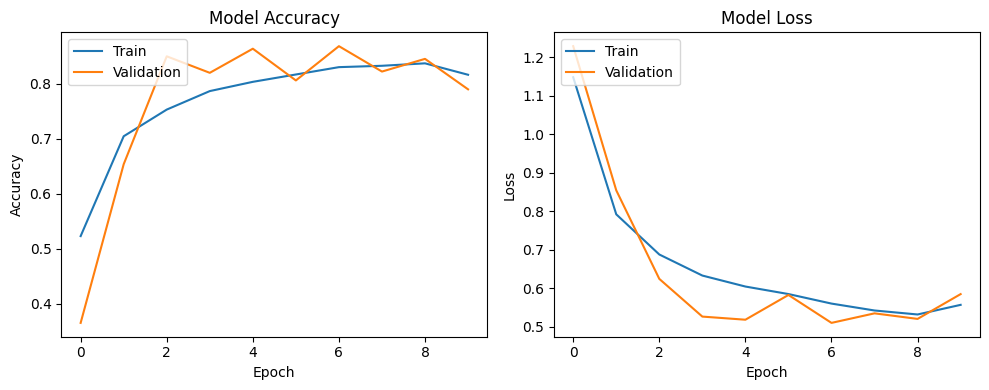

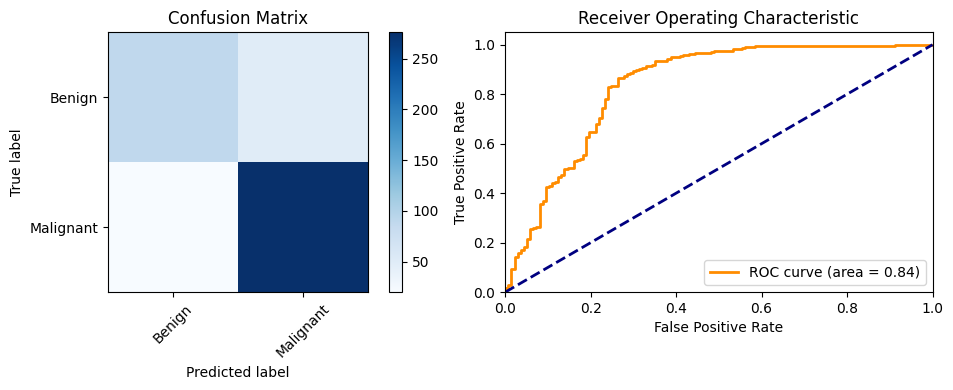

In [ ]:
# Function to plot accuracy and loss curves
def plot_metrics(history):
    plt.figure(figsize=(10, 4))  # Adjust the size to be smaller

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix and ROC curve side by side
def plot_confusion_matrix(y_test, y_pred_classes, y_pred_proba):
    plt.figure(figsize=(10, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot the training process metrics
plot_metrics(history)

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(y_histopath_test, y_pred_classes, y_pred_proba)


### Building a Dual-Stream ResNet50 Model for Multimodal Learning
This step involves constructing a dual-stream ResNet50 model to process both histopathological and mammographic images for breast cancer diagnosis. Each stream utilizes a pre-trained ResNet50 model to extract features from the respective image types. The extracted features are then concatenated and passed through dense layers with dropout to reduce overfitting. The model is compiled using the Adam optimizer with a low learning rate and binary cross-entropy loss. Early stopping is applied to prevent overfitting, and the model's performance is evaluated on a test set.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Function to build a ResNet50 model for a single input stream
def build_resnet50_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    return Model(inputs=base_model.input, outputs=x)

# Function to build a dual-stream ResNet50 model
def build_resnet50_dual_stream(input_shape_histopath, input_shape_mammo):
    # Stream 1: Histopathology images
    histopath_input = Input(shape=input_shape_histopath)
    histopath_model = build_resnet50_model(input_shape_histopath)
    x1 = histopath_model(histopath_input)

    # Stream 2: Mammographic images
    mammo_input = Input(shape=input_shape_mammo)
    mammo_model = build_resnet50_model(input_shape_mammo)
    x2 = mammo_model(mammo_input)

    # Concatenate the outputs of both streams
    concatenated = Concatenate()([x1, x2])
    x = Dense(256, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=[histopath_input, mammo_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# build and compile the ResNet50 model for dual input streams
resnet50_dual_stream_model = build_resnet50_dual_stream(
    input_shape_histopath=X_histopath_train.shape[1:],
    input_shape_mammo=X_mammo_train.shape[1:]
)

# Use early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the ResNet50 model
history_resnet50 = resnet50_dual_stream_model.fit(
    [X_histopath_train, X_mammo_train], y_histopath_train,
    epochs=10,
    validation_data=([X_histopath_val, X_mammo_val], y_histopath_val),
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the ResNet50 model on the test set
test_loss_resnet50, test_accuracy_resnet50 = resnet50_dual_stream_model.evaluate(
    [X_histopath_test, X_mammo_test], y_histopath_test, verbose=1
)
print(f"ResNet50 Test Loss: {test_loss_resnet50:.4f}, Test Accuracy: {test_accuracy_resnet50:.4f}")



Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 173s 926ms/step - accuracy: 0.5392 - loss: 1.1685 - val_accuracy: 0.6998 - val_loss: 0.6481
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7096 - loss: 0.5932 - val_accuracy: 0.6998 - val_loss: 0.6249
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.8100 - loss: 0.4318 - val_accuracy: 0.6998 - val_loss: 0.6159
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8503 - loss: 0.3505 - val_accuracy: 0.6998 - val_loss: 0.7195
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.8994 - loss: 0.2312 - val_accuracy: 0.6905 - val_loss: 0.7180
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9326 - loss: 0.1701 - val_accuracy: 0.6097 - val_loss: 0.6995
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 113ms/step - accuracy: 0.9400 - loss: 0.1358 - val_accuracy: 0.6513 - val_loss: 0.8064
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.9575 - loss: 0.1037 - val_accuracy: 

### Saving the ResNet50 Dual-Stream Model Checkpoint
 we save the trained ResNet50 dual-stream model, including its architecture, weights, and training history. The model architecture is saved as a JSON string, while the weights and history are stored as part of a dictionary. This dictionary is then saved to a specified file path using Python's pickle module. Storing this checkpoint allows for easy reloading and evaluation of the model without the need to retrain it.

In [ ]:
import pickle

# Define a checkpoint file path for the ResNet50 dual-stream model
resnet50_checkpoint_path = '/content/drive/MyDrive/dataset/resnet50_dual_stream_checkpoint.pkl'
# Create a dictionary to store the ResNet50 dual-stream model checkpoint
resnet50_checkpoint = {
    'model_architecture': resnet50_dual_stream_model.to_json(),  # Save model architecture as JSON
    'model_weights': resnet50_dual_stream_model.get_weights(),  # Save model weights
    'history': history_resnet50.history  # Save the training history
}
# Save the dictionary to a pickle file
with open(resnet50_checkpoint_path, 'wb') as file:
    pickle.dump(resnet50_checkpoint, file)

print(f"ResNet50 dual-stream model checkpoint saved to {resnet50_checkpoint_path}")



ResNet50 dual-stream model checkpoint saved to /content/drive/MyDrive/dataset/resnet50_dual_stream_checkpoint.pkl


### ResNet50 Dual-Stream Model Evaluation
We evaluate the ResNet50 dual-stream model on the test set, calculating key metrics like accuracy, precision, recall, F1 score, ROC AUC, and MCC. Additionally, we plot the accuracy and loss curves to visualize the model's training and validation performance.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Predict on the test set
y_pred_proba_resnet50 = resnet50_dual_stream_model.predict([X_histopath_test, X_mammo_test])
y_pred_classes_resnet50 = (y_pred_proba_resnet50 > 0.5).astype("int32")

# Calculate metrics
accuracy_resnet50 = accuracy_score(y_histopath_test, y_pred_classes_resnet50)
precision_resnet50 = precision_score(y_histopath_test, y_pred_classes_resnet50)
recall_resnet50 = recall_score(y_histopath_test, y_pred_classes_resnet50)
f1_resnet50 = f1_score(y_histopath_test, y_pred_classes_resnet50)
roc_auc_resnet50 = roc_auc_score(y_histopath_test, y_pred_proba_resnet50)
mcc_resnet50 = matthews_corrcoef(y_histopath_test, y_pred_classes_resnet50)

# Print the metrics
print(f'Accuracy: {accuracy_resnet50:.4f}')
print(f'Precision: {precision_resnet50:.4f}')
print(f'Recall: {recall_resnet50:.4f}')
print(f'F1 Score: {f1_resnet50:.4f}')
print(f'ROC AUC: {roc_auc_resnet50:.4f}')
print(f'MCC: {mcc_resnet50:.4f}')


14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 499ms/step
Accuracy: 0.6836
Precision: 0.6836
Recall: 1.0000
F1 Score: 0.8121
ROC AUC: 0.5329
MCC: 0.0000


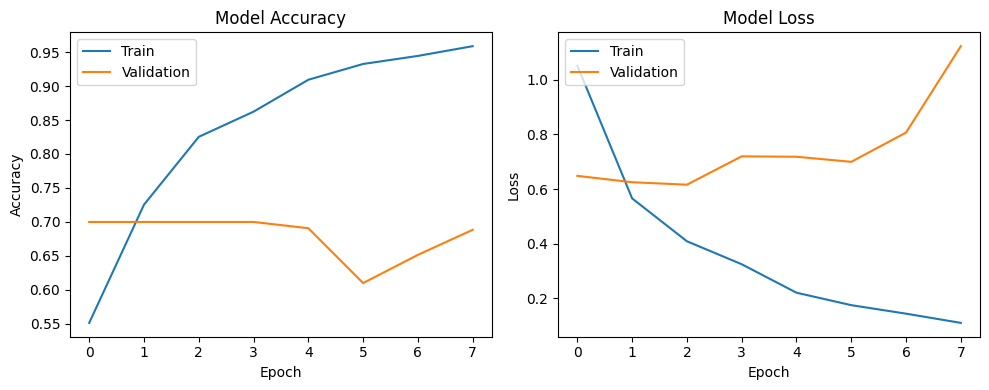

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_metrics(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot the training process metrics
plot_metrics(history_resnet50)


### Building a Dual-Stream DenseNet121 Model
Here is the construction of a dual-stream DenseNet121 model, designed to process both histopathological and mammographic images for breast cancer diagnosis. Each stream uses a DenseNet121 architecture pre-trained on ImageNet to extract relevant features from the input images. The outputs from the two streams are concatenated and passed through fully connected layers with ReLU activation and dropout to reduce overfitting. The final layer employs a sigmoid activation function for binary classification (benign or malignant). The model is compiled using the Adam optimizer with a learning rate of 1e-4, and the binary cross-entropy loss function. This architecture aims to leverage the combined features from both imaging modalities to improve diagnostic accuracy.

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Function to build a DenseNet121 model for a single input stream
def build_densenet_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    x = Flatten()(base_model.output)
    return Model(inputs=base_model.input, outputs=x)

# Function to build a dual-stream DenseNet121 model
def build_densenet_dual_stream(input_shape_histopath, input_shape_mammo):
    # Stream 1: Histopathology images
    histopath_input = Input(shape=input_shape_histopath)
    histopath_model = build_densenet_model(input_shape_histopath)
    x1 = histopath_model(histopath_input)

    # Stream 2: Mammographic images
    mammo_input = Input(shape=input_shape_mammo)
    mammo_model = build_densenet_model(input_shape_mammo)
    x2 = mammo_model(mammo_input)

    # Concatenate the outputs of both streams
    concatenated = Concatenate()([x1, x2])
    x = Dense(512, activation='relu')(concatenated)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=[histopath_input, mammo_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Build the DenseNet121 model for dual input streams
densenet_dual_stream_model = build_densenet_dual_stream(
    input_shape_histopath=X_histopath_train.shape[1:],
    input_shape_mammo=X_mammo_train.shape[1:]
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the DenseNet121 dual-stream model
history_densenet = densenet_dual_stream_model.fit(
    [X_histopath_train, X_mammo_train], y_histopath_train,
    epochs=10,  # Set epochs to 10 for consistent comparison
    batch_size=32,
    validation_data=([X_histopath_val, X_mammo_val], y_histopath_val),
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)
# Evaluate the DenseNet121 model on the test set
test_loss_densenet, test_accuracy_densenet = densenet_dual_stream_model.evaluate([X_histopath_test, X_mammo_test], y_histopath_test, verbose=1)
print(f"DenseNet121 Test Loss: {test_loss_densenet:.4f}, Test Accuracy: {test_accuracy_densenet:.4f}")


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.5464 - loss: 2.1985 - val_accuracy: 0.7044 - val_loss: 1.0057
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.8120 - loss: 0.5275 - val_accuracy: 0.7044 - val_loss: 1.7409
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.8939 - loss: 0.2478 - val_accuracy: 0.7113 - val_loss: 1.9127
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9449 - loss: 0.1303 - val_accuracy: 0.7229 - val_loss: 1.5208
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9632 - loss: 0.1064 - val_accuracy: 0.8984 - val_loss: 0.4203
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9714 - loss: 0.0721 - val_accuracy: 0.9330 - val_loss: 0.3108
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.9809 - loss: 0.0670 - val_accuracy: 0.9307 - val_loss: 0.4557
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 0.9837 - loss: 0.0534 - val_accurac

### Saving the densenet121 dual stream model to a checkpoint

In [ ]:
import pickle

# Define the checkpoint file path for the DenseNet121 dual-stream model
densenet_checkpoint_path = '/content/drive/MyDrive/dataset/densenet_dual_stream_checkpoint.pkl'

# Create a dictionary to store the DenseNet121 dual-stream model and related data
densenet_checkpoint = {
    'model': densenet_dual_stream_model,
    'history': history_densenet.history,
    'test_loss': test_loss_densenet,
    'test_accuracy': test_accuracy_densenet
}

# Save the dictionary to a pickle file
with open(densenet_checkpoint_path, 'wb') as file:
    pickle.dump(densenet_checkpoint, file)

print(f"DenseNet121 dual-stream model checkpoint saved to {densenet_checkpoint_path}")


DenseNet121 dual-stream model checkpoint saved to /content/drive/MyDrive/dataset/densenet_dual_stream_checkpoint.pkl


### Evaluating the DenseNet121 Dual-Stream Model
We evaluate the DenseNet121 dual-stream model by calculating metrics like accuracy, precision, recall, F1 score, ROC AUC, and MCC on the test set. We also visualize training history with accuracy and loss plots, and assess model performance using a confusion matrix and ROC curve.

14/14 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step
Accuracy: 0.9192
Precision: 0.9424
Recall: 0.9392
F1 Score: 0.9408
ROC AUC: 0.9699
MCC: 0.8135


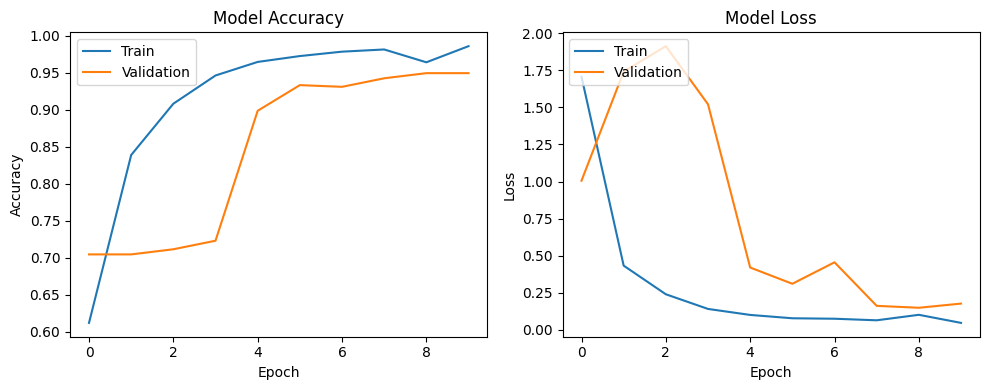

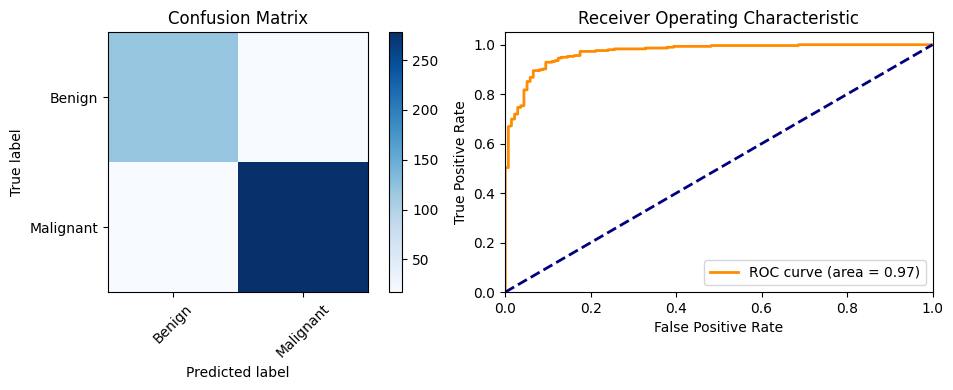

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_proba_densenet = densenet_dual_stream_model.predict([X_histopath_test, X_mammo_test])
y_pred_classes_densenet = (y_pred_proba_densenet > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy_densenet = accuracy_score(y_histopath_test, y_pred_classes_densenet)
precision_densenet = precision_score(y_histopath_test, y_pred_classes_densenet)
recall_densenet = recall_score(y_histopath_test, y_pred_classes_densenet)
f1_densenet = f1_score(y_histopath_test, y_pred_classes_densenet)
roc_auc_densenet = roc_auc_score(y_histopath_test, y_pred_proba_densenet)
mcc_densenet = matthews_corrcoef(y_histopath_test, y_pred_classes_densenet)

# Print evaluation metrics
print(f'Accuracy: {accuracy_densenet:.4f}')
print(f'Precision: {precision_densenet:.4f}')
print(f'Recall: {recall_densenet:.4f}')
print(f'F1 Score: {f1_densenet:.4f}')
print(f'ROC AUC: {roc_auc_densenet:.4f}')
print(f'MCC: {mcc_densenet:.4f}')

# Function to plot accuracy and loss curves
def plot_metrics(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train')
    plt.plot(history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix and ROC curve side by side
def plot_confusion_matrix(y_true, y_pred_classes, y_pred_proba):
    plt.figure(figsize=(10, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot the training process metrics
plot_metrics(history_densenet.history)

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(y_histopath_test, y_pred_classes_densenet, y_pred_proba_densenet)


# Multimodality: Dual Input Streams with Feature Engineering using Custom CNN for Histopathological and Mammographic Data

### Loading BreakHis and CBIS-DDSM Datasets
 we load the preprocessed datasets for BreakHis and CBIS-DDSM. The BreakHis dataset is retrieved from a saved checkpoint, containing a specific number of images and their corresponding labels. Similarly, the CBIS-DDSM dataset is loaded from its checkpoint, also providing the images and labels necessary for further processing. This setup allows us to prepare the data for the upcoming multimodal analysis using custom CNNs with feature engineering.

In [ ]:
import pickle

# Load BreakHis dataset checkpoint
breakhis_checkpoint_path = '/content/drive/MyDrive/dataset/breakhis_checkpoint.pkl'
with open(breakhis_checkpoint_path, 'rb') as file:
    breakhis_checkpoint = pickle.load(file)
breakhis_images = breakhis_checkpoint['breakhis_images']
breakhis_labels = breakhis_checkpoint['breakhis_labels']

print(f'Loaded BreakHis dataset from checkpoint with {breakhis_images.shape[0]} images.')

# Load the CBIS-DDSM dataset checkpoint
cbis_ddsm_checkpoint_path = '/content/drive/MyDrive/dataset/cbis_ddsm_preprocessed_checkpoint.pkl'
with open(cbis_ddsm_checkpoint_path, 'rb') as file:
    cbis_ddsm_checkpoint = pickle.load(file)
cbis_ddsm_images = cbis_ddsm_checkpoint['cbis_ddsm_images']
cbis_ddsm_labels = cbis_ddsm_checkpoint['cbis_ddsm_labels']

print(f'Loaded CBIS-DDSM dataset from checkpoint with {cbis_ddsm_images.shape[0]} images.')


Loaded BreakHis dataset from checkpoint with 7909 images.
Loaded CBIS-DDSM dataset from checkpoint with 2886 images.


### Splitting the Datasets into Training, Validation, and Test Sets
Here, we divide the BreakHis and CBIS-DDSM datasets into separate training, validation, and test sets. For each dataset, 70% of the images are allocated for training, while the remaining 30% is further split evenly between validation and test sets. This stratified split ensures that the class distribution remains consistent across each subset. The resulting shapes of these splits are printed to confirm that the data is correctly partitioned for subsequent model training and evaluation.

In [ ]:
from sklearn.model_selection import train_test_split

# Split BreakHis dataset into training (70%), validation (15%), and test (15%) sets
X_histopath_train, X_histopath_temp, y_histopath_train, y_histopath_temp = train_test_split(
    breakhis_images, breakhis_labels, test_size=0.3, stratify=breakhis_labels, random_state=42
)

X_histopath_val, X_histopath_test, y_histopath_val, y_histopath_test = train_test_split(
    X_histopath_temp, y_histopath_temp, test_size=0.5, stratify=y_histopath_temp, random_state=42
)

# Split CBIS-DDSM dataset into training (70%), validation (15%), and test (15%) sets
X_mammo_train, X_mammo_temp, y_mammo_train, y_mammo_temp = train_test_split(
    cbis_ddsm_images, cbis_ddsm_labels, test_size=0.3, stratify=cbis_ddsm_labels, random_state=42
)

X_mammo_val, X_mammo_test, y_mammo_val, y_mammo_test = train_test_split(
    X_mammo_temp, y_mammo_temp, test_size=0.5, stratify=y_mammo_temp, random_state=42
)

# Verify the shape of the splits
print(f"Histopath Training Set Shape: {X_histopath_train.shape}, Labels: {y_histopath_train.shape}")
print(f"Histopath Validation Set Shape: {X_histopath_val.shape}, Labels: {y_histopath_val.shape}")
print(f"Histopath Test Set Shape: {X_histopath_test.shape}, Labels: {y_histopath_test.shape}")

print(f"Mammo Training Set Shape: {X_mammo_train.shape}, Labels: {y_mammo_train.shape}")
print(f"Mammo Validation Set Shape: {X_mammo_val.shape}, Labels: {y_mammo_val.shape}")
print(f"Mammo Test Set Shape: {X_mammo_test.shape}, Labels: {y_mammo_test.shape}")


Histopath Training Set Shape: (5536, 224, 224, 3), Labels: (5536,)
Histopath Validation Set Shape: (1186, 224, 224, 3), Labels: (1186,)
Histopath Test Set Shape: (1187, 224, 224, 3), Labels: (1187,)
Mammo Training Set Shape: (2020, 224, 224, 3), Labels: (2020,)
Mammo Validation Set Shape: (433, 224, 224, 3), Labels: (433,)
Mammo Test Set Shape: (433, 224, 224, 3), Labels: (433,)


# Extract Traditional Features
a. For Mammographic Images (CBIS-DDSM Dataset)

In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.9 MB/s eta 0:00:00


### Extracting Traditional Features from Mammographic Images
This code extracts traditional features from mammographic images in the CBIS-DDSM dataset. The images are first converted to grayscale, followed by the extraction of several key features: HOG (Histogram of Oriented Gradients) captures edge patterns, wavelet transform features provide multi-scale spatial and frequency information, fractal dimension estimates texture complexity, and texture entropy measures randomness in the image. These features are combined into a single feature set for each image, then standardized to ensure consistency in scale, preparing them for model training. The output confirms the dimensions of these extracted features.

In [ ]:
import cv2
import numpy as np
import pywt
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy

# Function to preprocess image to grayscale
def preprocess_image(image):
    image = (image * 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Function to extract HOG features
def extract_hog_features(image):
    return hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)

# Function to extract Wavelet Transform features
def extract_wavelet_features(image):
    coeffs = pywt.wavedec2(image, 'db1', level=2)
    features = [coeffs[0].flatten()]  # Approximation coefficients
    for detail_level in coeffs[1:]:
        features.extend([coeff.flatten() for coeff in detail_level])
    return np.hstack(features)

# Function to estimate fractal dimension using box-counting method
def fractal_dimension(image):
    # Binarize the image
    image_bin = (image > image.mean()).astype(np.uint8)

    # Define sizes of the boxes
    sizes = np.arange(1, 11)
    counts = []

    for size in sizes:
        count = np.sum(image_bin[::size, ::size])
        counts.append(count)

    # Fit a line to log-log data
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return coeffs[0]  # The slope of the line

# Function to extract Texture Entropy features
def extract_entropy_features(image):
    return entropy(image.ravel())

# Function to extract all traditional features for mammographic images
def extract_mammo_features(X_data):
    hog_features = []
    wavelet_features = []
    fractal_features = []
    entropy_features = []

    for image in X_data:
        image_gray = preprocess_image(image)  # Preprocess the image to grayscale

        hog_feat = extract_hog_features(image_gray)
        wavelet_feat = extract_wavelet_features(image_gray)
        fractal_feat = fractal_dimension(image_gray)
        entropy_feat = extract_entropy_features(image_gray)

        hog_features.append(hog_feat)
        wavelet_features.append(wavelet_feat)
        fractal_features.append(fractal_feat)
        entropy_features.append(entropy_feat)

    # Combine all traditional features into one array
    hog_features = np.array(hog_features)
    wavelet_features = np.array(wavelet_features)
    fractal_features = np.array(fractal_features).reshape(-1, 1)  # Reshape to 2D array
    entropy_features = np.array(entropy_features).reshape(-1, 1)  # Reshape to 2D array

    traditional_features = np.hstack([hog_features, wavelet_features, fractal_features, entropy_features])

    # Standardize features
    scaler = StandardScaler()
    traditional_features = scaler.fit_transform(traditional_features)

    return traditional_features

# Extract traditional features for mammographic images
mammo_traditional_features_train = extract_mammo_features(X_mammo_train)
mammo_traditional_features_val = extract_mammo_features(X_mammo_val)
mammo_traditional_features_test = extract_mammo_features(X_mammo_test)

print(f"Mammo Traditional Features Shape: {mammo_traditional_features_train.shape}")


Mammo Traditional Features Shape: (2020, 76422)


 Prepare the Data cbis-ddsm for Saving and Save the Features to a Checkpoint File

In [ ]:
import pickle

# Organize the traditional features into a dictionary
mammo_traditional_features = {
    'train': mammo_traditional_features_train,
    'val': mammo_traditional_features_val,
    'test': mammo_traditional_features_test
}
# Define the checkpoint file path
mammo_features_checkpoint_path = '/content/drive/MyDrive/dataset/mammo_traditional_features2_checkpoint.pkl'

# Save the traditional features dictionary as a checkpoint
with open(mammo_features_checkpoint_path, 'wb') as file:
    pickle.dump(mammo_traditional_features, file)

print(f"Traditional features for mammographic images saved to {mammo_features_checkpoint_path}.")


Traditional features for mammographic images saved to /content/drive/MyDrive/dataset/mammo_traditional_features2_checkpoint.pkl.


### Extracting Traditional Features from Histopathological Images
 we extract traditional features from the histopathological images in the BreakHis dataset. The features include GLCM (Gray Level Co-occurrence Matrix) for texture analysis, LBP (Local Binary Patterns) for capturing local texture, Haralick features for statistical texture description, and HOG (Histogram of Oriented Gradients) for edge orientation patterns. The extracted features are combined into a comprehensive feature set for each image and then standardized to ensure uniformity. The processed feature sets are prepared for use in model training, with the final output verifying the dimensions of these features.

In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern, hog
from sklearn.preprocessing import StandardScaler
import mahotas as mt

# Function to extract GLCM features
def extract_glcm_features(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True):
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=symmetric, normed=normed)
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    return np.hstack([contrast, dissimilarity, homogeneity, energy, correlation])

# Function to extract LBP features
def extract_lbp_features(image, P=8, R=1.0):
    lbp = local_binary_pattern(image, P, R, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

# Function to extract Haralick features
def extract_haralick_features(image):
    return mt.features.haralick(image).mean(axis=0)

# Function to extract all traditional features for histopathological images
def extract_histopath_features(X_data):
    glcm_features = []
    lbp_features = []
    haralick_features = []
    hog_features = []

    for image in X_data:
        # Convert to uint8 before processing
        image_uint8 = (image * 255).astype(np.uint8)
        image_gray = cv2.cvtColor(image_uint8, cv2.COLOR_RGB2GRAY)

        glcm = extract_glcm_features(image_gray)
        lbp = extract_lbp_features(image_gray)
        haralick = extract_haralick_features(image_gray)
        hog_feat = extract_hog_features(image_gray)

        glcm_features.append(glcm)
        lbp_features.append(lbp)
        haralick_features.append(haralick)
        hog_features.append(hog_feat)

    # Combine all traditional features into one array
    glcm_features = np.array(glcm_features)
    lbp_features = np.array(lbp_features)
    haralick_features = np.array(haralick_features)
    hog_features = np.array(hog_features)

    traditional_features = np.hstack([glcm_features, lbp_features, haralick_features, hog_features])

    # Standardize features
    scaler = StandardScaler()
    traditional_features = scaler.fit_transform(traditional_features)

    return traditional_features

# Extract traditional features for histopathological images
histopath_traditional_features_train = extract_histopath_features(X_histopath_train)
histopath_traditional_features_val = extract_histopath_features(X_histopath_val)
histopath_traditional_features_test = extract_histopath_features(X_histopath_test)

print(f"Histopath Traditional Features Shape: {histopath_traditional_features_train.shape}")


Histopath Traditional Features Shape: (5536, 26272)


 Prepare the Data BreakHis for Saving and Save the Features to a Checkpoint File

In [ ]:
import pickle

# Organize the traditional features into a dictionary
histopath_traditional_features = {
    'train': histopath_traditional_features_train,
    'val': histopath_traditional_features_val,
    'test': histopath_traditional_features_test
}
# Define the checkpoint file path
histopath_features_checkpoint_path = '/content/drive/MyDrive/dataset/histopath_traditional_features_checkpoint.pkl'

# Save the traditional features dictionary as a checkpoint
with open(histopath_features_checkpoint_path, 'wb') as file:
    pickle.dump(histopath_traditional_features, file)

print(f"Traditional features for histopathological images saved to {histopath_features_checkpoint_path}.")


Traditional features for histopathological images saved to /content/drive/MyDrive/dataset/histopath_traditional_features_checkpoint.pkl.


### Building a Regularized Dual-Stream CNN for Multimodal Learning
we a dual-stream Convolutional Neural Network (CNN) model that processes both histopathological and mammographic images simultaneously. The model architecture includes two separate input streams: one for histopathological images and one for mammographic images. Each stream passes through multiple convolutional layers with L2 regularization and max-pooling layers to extract features. These streams are then combined and passed through fully connected layers with dropout for regularization. The final output layer uses a sigmoid activation to predict whether the input images indicate benign or malignant cases. The model is compiled using the Adam optimizer with binary cross-entropy as the loss function, and accuracy as the evaluation metric.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_dual_stream_cnn_with_regularization(input_shape_histopath, input_shape_mammo):
    # Stream 1: Histopathology images
    histopath_input = Input(shape=input_shape_histopath)
    x1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(histopath_input)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x1)
    x1 = MaxPooling2D((2, 2))(x1)
    x1 = Flatten()(x1)

    # Stream 2: Mammography images
    mammo_input = Input(shape=input_shape_mammo)
    x2 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(mammo_input)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(x2)
    x2 = MaxPooling2D((2, 2))(x2)
    x2 = Flatten()(x2)

    # Combine both streams
    combined = concatenate([x1, x2])
    combined = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = Dropout(0.5)(combined)
    combined = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(1, activation='sigmoid')(combined)

    model = Model(inputs=[histopath_input, mammo_input], outputs=output)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
# Define the model
dual_stream_model = build_dual_stream_cnn_with_regularization(
    input_shape_histopath=X_histopath_train.shape[1:],
    input_shape_mammo=X_mammo_train.shape[1:]
)




 Calculate and Use Class Weights:
Class weights can be computed using sklearn to balance the training process.

In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Calculate class weights based on the histopathology training labels
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_histopath_train), y=y_histopath_train)
class_weights = dict(enumerate(class_weights))

print(f"Class Weights: {class_weights}")


Class Weights: {0: 1.5944700460829493, 1: 0.728421052631579}


In [ ]:
print(f"X_histopath_train shape: {X_histopath_train.shape}")
print(f"X_mammo_train shape: {X_mammo_train.shape}")
print(f"y_histopath_train shape: {y_histopath_train.shape}")


X_histopath_train shape: (5536, 224, 224, 3)
X_mammo_train shape: (2020, 224, 224, 3)
y_histopath_train shape: (5536,)


In [ ]:
# Ensure that both datasets have the same number of samples
min_samples = min(X_histopath_train.shape[0], X_mammo_train.shape[0])

X_histopath_train = X_histopath_train[:min_samples]
y_histopath_train = y_histopath_train[:min_samples]

X_mammo_train = X_mammo_train[:min_samples]

X_histopath_val = X_histopath_val[:min_samples]
y_histopath_val = y_histopath_val[:min_samples]

X_mammo_val = X_mammo_val[:min_samples]

X_histopath_test = X_histopath_test[:min_samples]
y_histopath_test = y_histopath_test[:min_samples]

X_mammo_test = X_mammo_test[:min_samples]


In [ ]:
# Ensure that both datasets have the same number of samples for training
min_samples_train = min(X_histopath_train.shape[0], X_mammo_train.shape[0])

X_histopath_train = X_histopath_train[:min_samples_train]
y_histopath_train = y_histopath_train[:min_samples_train]

X_mammo_train = X_mammo_train[:min_samples_train]

# Ensure that both datasets have the same number of samples for validation
min_samples_val = min(X_histopath_val.shape[0], X_mammo_val.shape[0])

X_histopath_val = X_histopath_val[:min_samples_val]
y_histopath_val = y_histopath_val[:min_samples_val]

X_mammo_val = X_mammo_val[:min_samples_val]

# Now try fitting the model again
history = dual_stream_model.fit(
    [X_histopath_train, X_mammo_train], y_histopath_train,
    epochs=10,
    validation_data=([X_histopath_val, X_mammo_val], y_histopath_val),
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.6269 - loss: 0.8444 - val_accuracy: 0.5889 - val_loss: 1.1977
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7583 - loss: 0.7387 - val_accuracy: 0.8337 - val_loss: 0.5683
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8238 - loss: 0.6317 - val_accuracy: 0.8222 - val_loss: 0.5545
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.8268 - loss: 0.5943 - val_accuracy: 0.7206 - val_loss: 0.7449
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7801 - loss: 0.6255 - val_accuracy: 0.7714 - val_loss: 0.6152
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7518 - loss: 0.6570 - val_accuracy: 0.8037 - val_loss: 0.5784
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8118 - loss: 0.5797 - val_accuracy: 0.8129 - val_loss: 0.5354
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8227 - loss: 0.5614 - val_accuracy: 0.8453 - 

In [ ]:
# Ensure that both datasets have the same number of samples for testing
min_samples_test = min(X_histopath_test.shape[0], X_mammo_test.shape[0])

X_histopath_test = X_histopath_test[:min_samples_test]
y_histopath_test = y_histopath_test[:min_samples_test]

X_mammo_test = X_mammo_test[:min_samples_test]

# Evaluate the model on the test set
test_loss, test_accuracy = dual_stream_model.evaluate([X_histopath_test, X_mammo_test], y_histopath_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8851 - loss: 0.4362
Test Loss: 0.4497, Test Accuracy: 0.8776


Saving the model to a checkpoint

In [ ]:
import pickle

# Save model architecture
model_architecture = dual_stream_model.to_json()

# Save model weights
model_weights = dual_stream_model.get_weights()

# Define the path to save the model
model_checkpoint_path = '/content/drive/MyDrive/dataset/dual_stream_cnn_model.pkl'

# Save both architecture and weights using pickle
with open(model_checkpoint_path, 'wb') as file:
    pickle.dump({'architecture': model_architecture, 'weights': model_weights}, file)

print(f"Model architecture and weights saved to {model_checkpoint_path}")


Model architecture and weights saved to /content/drive/MyDrive/dataset/dual_stream_cnn_model.pkl


### Evaluation metrics and plots

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Accuracy: 0.8776
Precision: 0.8780
Recall: 0.9568
F1 Score: 0.9157
ROC AUC: 0.8720
MCC: 0.7022


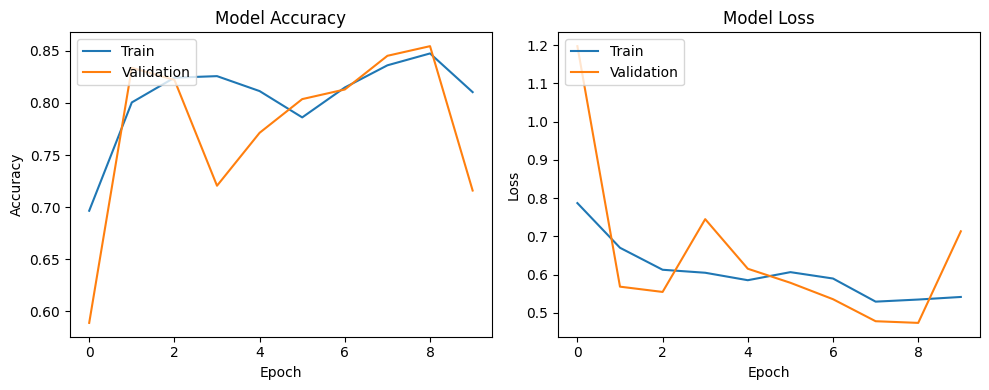

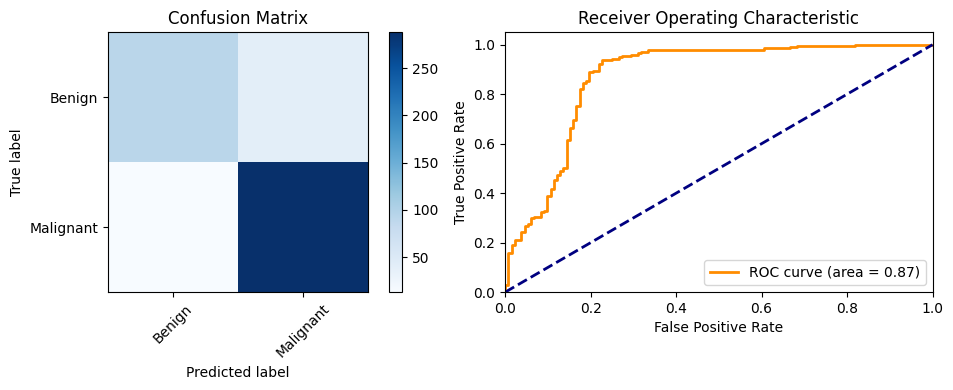

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, matthews_corrcoef, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_proba = dual_stream_model.predict([X_histopath_test, X_mammo_test])  # Replace with your model name if different
y_pred_classes = (y_pred_proba > 0.5).astype("int32")

# Calculate evaluation metrics
accuracy = accuracy_score(y_histopath_test, y_pred_classes)
precision = precision_score(y_histopath_test, y_pred_classes)
recall = recall_score(y_histopath_test, y_pred_classes)
f1 = f1_score(y_histopath_test, y_pred_classes)
roc_auc = roc_auc_score(y_histopath_test, y_pred_proba)
mcc = matthews_corrcoef(y_histopath_test, y_pred_classes)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'MCC: {mcc:.4f}')

# Function to plot accuracy and loss curves
def plot_metrics(history):
    plt.figure(figsize=(10, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# Function to plot confusion matrix and ROC curve side by side
def plot_confusion_matrix(y_true, y_pred_classes, y_pred_proba):
    plt.figure(figsize=(10, 4))

    # Plot Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
    plt.yticks(tick_marks, ['Benign', 'Malignant'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

# Plot the training process metrics
plot_metrics(history)

# Plot the confusion matrix and ROC curve
plot_confusion_matrix(y_histopath_test, y_pred_classes, y_pred_proba)


End